### MagicLeap's Implementation of SuperPoint
modified by Vardhan Dongre

In [3]:
import argparse
import glob
import numpy as np
import os
import time

import cv2
import torch

# Stub to warn about opencv version.
if int(cv2.__version__[0]) < 3: # pragma: no cover
  print('Warning: OpenCV 3 is not installed')

# Jet colormap for visualization.
myjet = np.array([[0.        , 0.        , 0.5       ],
                  [0.        , 0.        , 0.99910873],
                  [0.        , 0.37843137, 1.        ],
                  [0.        , 0.83333333, 1.        ],
                  [0.30044276, 1.        , 0.66729918],
                  [0.66729918, 1.        , 0.30044276],
                  [1.        , 0.90123457, 0.        ],
                  [1.        , 0.48002905, 0.        ],
                  [0.99910873, 0.07334786, 0.        ],
                  [0.5       , 0.        , 0.        ]])

class SuperPointNet(torch.nn.Module):
  """ Pytorch definition of SuperPoint Network. """
  def __init__(self):
    super(SuperPointNet, self).__init__()
    self.relu = torch.nn.ReLU(inplace=True)
    self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
    c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
    # Shared Encoder.
    self.conv1a = torch.nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
    self.conv1b = torch.nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
    self.conv2a = torch.nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
    self.conv2b = torch.nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
    self.conv3a = torch.nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
    self.conv3b = torch.nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
    self.conv4a = torch.nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
    self.conv4b = torch.nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
    # Detector Head.
    self.convPa = torch.nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
    self.convPb = torch.nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
    # Descriptor Head.
    self.convDa = torch.nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
    self.convDb = torch.nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

  def forward(self, x):
    """ Forward pass that jointly computes unprocessed point and descriptor
    tensors.
    Input
      x: Image pytorch tensor shaped N x 1 x H x W.
    Output
      semi: Output point pytorch tensor shaped N x 65 x H/8 x W/8.
      desc: Output descriptor pytorch tensor shaped N x 256 x H/8 x W/8.
    """
    # Shared Encoder.
    x = self.relu(self.conv1a(x))
    x = self.relu(self.conv1b(x))
    x = self.pool(x)
    x = self.relu(self.conv2a(x))
    x = self.relu(self.conv2b(x))
    x = self.pool(x)
    x = self.relu(self.conv3a(x))
    x = self.relu(self.conv3b(x))
    x = self.pool(x)
    x = self.relu(self.conv4a(x))
    x = self.relu(self.conv4b(x))
    # Detector Head.
    cPa = self.relu(self.convPa(x))
    semi = self.convPb(cPa)
    # Descriptor Head.
    cDa = self.relu(self.convDa(x))
    desc = self.convDb(cDa)
    dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
    desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
    return semi, desc


class SuperPointFrontend(object):
  """ Wrapper around pytorch net to help with pre and post image processing. """
  def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,
               cuda=False):
    self.name = 'SuperPoint'
    self.cuda = cuda
    self.nms_dist = nms_dist
    self.conf_thresh = conf_thresh
    self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
    self.cell = 8 # Size of each output cell. Keep this fixed.
    self.border_remove = 4 # Remove points this close to the border.

    # Load the network in inference mode.
    self.net = SuperPointNet()
    if cuda:
      # Train on GPU, deploy on GPU.
      self.net.load_state_dict(torch.load(weights_path))
      self.net = self.net.cuda()
    else:
      # Train on GPU, deploy on CPU.
      self.net.load_state_dict(torch.load(weights_path,
                               map_location=lambda storage, loc: storage))
    self.net.eval()

  def nms_fast(self, in_corners, H, W, dist_thresh):
    """
    Run a faster approximate Non-Max-Suppression on numpy corners shaped:
      3xN [x_i,y_i,conf_i]^T
  
    Algo summary: Create a grid sized HxW. Assign each corner location a 1, rest
    are zeros. Iterate through all the 1's and convert them either to -1 or 0.
    Suppress points by setting nearby values to 0.
  
    Grid Value Legend:
    -1 : Kept.
     0 : Empty or suppressed.
     1 : To be processed (converted to either kept or supressed).
  
    NOTE: The NMS first rounds points to integers, so NMS distance might not
    be exactly dist_thresh. It also assumes points are within image boundaries.
  
    Inputs
      in_corners - 3xN numpy array with corners [x_i, y_i, confidence_i]^T.
      H - Image height.
      W - Image width.
      dist_thresh - Distance to suppress, measured as an infinty norm distance.
    Returns
      nmsed_corners - 3xN numpy matrix with surviving corners.
      nmsed_inds - N length numpy vector with surviving corner indices.
    """
    grid = np.zeros((H, W)).astype(int) # Track NMS data.
    inds = np.zeros((H, W)).astype(int) # Store indices of points.
    # Sort by confidence and round to nearest int.
    inds1 = np.argsort(-in_corners[2,:])
    corners = in_corners[:,inds1]
    rcorners = corners[:2,:].round().astype(int) # Rounded corners.
    # Check for edge case of 0 or 1 corners.
    if rcorners.shape[1] == 0:
      return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
    if rcorners.shape[1] == 1:
      out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
      return out, np.zeros((1)).astype(int)
    # Initialize the grid.
    for i, rc in enumerate(rcorners.T):
      grid[rcorners[1,i], rcorners[0,i]] = 1
      inds[rcorners[1,i], rcorners[0,i]] = i
    # Pad the border of the grid, so that we can NMS points near the border.
    pad = dist_thresh
    grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
    # Iterate through points, highest to lowest conf, suppress neighborhood.
    count = 0
    for i, rc in enumerate(rcorners.T):
      # Account for top and left padding.
      pt = (rc[0]+pad, rc[1]+pad)
      if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
        grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
        grid[pt[1], pt[0]] = -1
        count += 1
    # Get all surviving -1's and return sorted array of remaining corners.
    keepy, keepx = np.where(grid==-1)
    keepy, keepx = keepy - pad, keepx - pad
    inds_keep = inds[keepy, keepx]
    out = corners[:, inds_keep]
    values = out[-1, :]
    inds2 = np.argsort(-values)
    out = out[:, inds2]
    out_inds = inds1[inds_keep[inds2]]
    return out, out_inds

  def run(self, img):
    """ Process a numpy image to extract points and descriptors.
    Input
      img - HxW numpy float32 input image in range [0,1].
    Output
      corners - 3xN numpy array with corners [x_i, y_i, confidence_i]^T.
      desc - 256xN numpy array of corresponding unit normalized descriptors.
      heatmap - HxW numpy heatmap in range [0,1] of point confidences.
      """
    assert img.ndim == 2, 'Image must be grayscale.'
    assert img.dtype == np.float32, 'Image must be float32.'
    H, W = img.shape[0], img.shape[1]
    inp = img.copy()
    inp = (inp.reshape(1, H, W))
    inp = torch.from_numpy(inp)
    inp = torch.autograd.Variable(inp).view(1, 1, H, W)
    if self.cuda:
      inp = inp.cuda()
    # Forward pass of network.
    outs = self.net.forward(inp)
    semi, coarse_desc = outs[0], outs[1]
    # Convert pytorch -> numpy.
    semi = semi.data.cpu().numpy().squeeze()
    # --- Process points.
    dense = np.exp(semi) # Softmax.
    dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
    # Remove dustbin.
    nodust = dense[:-1, :, :]
    # Reshape to get full resolution heatmap.
    Hc = int(H / self.cell)
    Wc = int(W / self.cell)
    nodust = nodust.transpose(1, 2, 0)
    heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
    heatmap = np.transpose(heatmap, [0, 2, 1, 3])
    heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell])
    xs, ys = np.where(heatmap >= self.conf_thresh) # Confidence threshold.
    if len(xs) == 0:
      return np.zeros((3, 0)), None, None
    pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
    pts[0, :] = ys
    pts[1, :] = xs
    pts[2, :] = heatmap[xs, ys]
    pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
    inds = np.argsort(pts[2,:])
    pts = pts[:,inds[::-1]] # Sort by confidence.
    # Remove points along border.
    bord = self.border_remove
    toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
    toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
    toremove = np.logical_or(toremoveW, toremoveH)
    pts = pts[:, ~toremove]
    # --- Process descriptor.
    D = coarse_desc.shape[1]
    if pts.shape[1] == 0:
      desc = np.zeros((D, 0))
    else:
      # Interpolate into descriptor map using 2D point locations.
      samp_pts = torch.from_numpy(pts[:2, :].copy())
      samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
      samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
      samp_pts = samp_pts.transpose(0, 1).contiguous()
      samp_pts = samp_pts.view(1, 1, -1, 2)
      samp_pts = samp_pts.float()
      if self.cuda:
        samp_pts = samp_pts.cuda()
      desc = torch.nn.functional.grid_sample(coarse_desc, samp_pts)
      desc = desc.data.cpu().numpy().reshape(D, -1)
      desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]
    return pts, desc, heatmap


class PointTracker(object):
  """ Class to manage a fixed memory of points and descriptors that enables
  sparse optical flow point tracking.

  Internally, the tracker stores a 'tracks' matrix sized M x (2+L), of M
  tracks with maximum length L, where each row corresponds to:
  row_m = [track_id_m, avg_desc_score_m, point_id_0_m, ..., point_id_L-1_m].
  """

  def __init__(self, max_length, nn_thresh):
    if max_length < 2:
      raise ValueError('max_length must be greater than or equal to 2.')
    self.maxl = max_length
    self.nn_thresh = nn_thresh
    self.all_pts = []
    for n in range(self.maxl):
      self.all_pts.append(np.zeros((2, 0)))
    self.last_desc = None
    self.tracks = np.zeros((0, self.maxl+2))
    self.track_count = 0
    self.max_score = 9999

  def nn_match_two_way(self, desc1, desc2, nn_thresh):
    """
    Performs two-way nearest neighbor matching of two sets of descriptors, such
    that the NN match from descriptor A->B must equal the NN match from B->A.

    Inputs:
      desc1 - NxM numpy matrix of N corresponding M-dimensional descriptors.
      desc2 - NxM numpy matrix of N corresponding M-dimensional descriptors.
      nn_thresh - Optional descriptor distance below which is a good match.

    Returns:
      matches - 3xL numpy array, of L matches, where L <= N and each column i is
                a match of two descriptors, d_i in image 1 and d_j' in image 2:
                [d_i index, d_j' index, match_score]^T
    """
    assert desc1.shape[0] == desc2.shape[0]
    if desc1.shape[1] == 0 or desc2.shape[1] == 0:
      return np.zeros((3, 0))
    if nn_thresh < 0.0:
      raise ValueError('\'nn_thresh\' should be non-negative')
    # Compute L2 distance. Easy since vectors are unit normalized.
    dmat = np.dot(desc1.T, desc2)
    dmat = np.sqrt(2-2*np.clip(dmat, -1, 1))
    # Get NN indices and scores.
    idx = np.argmin(dmat, axis=1)
    scores = dmat[np.arange(dmat.shape[0]), idx]
    # Threshold the NN matches.
    keep = scores < nn_thresh
    # Check if nearest neighbor goes both directions and keep those.
    idx2 = np.argmin(dmat, axis=0)
    keep_bi = np.arange(len(idx)) == idx2[idx]
    keep = np.logical_and(keep, keep_bi)
    idx = idx[keep]
    scores = scores[keep]
    # Get the surviving point indices.
    m_idx1 = np.arange(desc1.shape[1])[keep]
    m_idx2 = idx
    # Populate the final 3xN match data structure.
    matches = np.zeros((3, int(keep.sum())))
    matches[0, :] = m_idx1
    matches[1, :] = m_idx2
    matches[2, :] = scores
    return matches

  def get_offsets(self):
    """ Iterate through list of points and accumulate an offset value. Used to
    index the global point IDs into the list of points.

    Returns
      offsets - N length array with integer offset locations.
    """
    # Compute id offsets.
    offsets = []
    offsets.append(0)
    for i in range(len(self.all_pts)-1): # Skip last camera size, not needed.
      offsets.append(self.all_pts[i].shape[1])
    offsets = np.array(offsets)
    offsets = np.cumsum(offsets)
    return offsets
  

  def update(self, pts, desc):
    """ Add a new set of point and descriptor observations to the tracker.

    Inputs
      pts - 3xN numpy array of 2D point observations.
      desc - DxN numpy array of corresponding D dimensional descriptors.
    """
    if pts is None or desc is None:
      print('PointTracker: Warning, no points were added to tracker.')
      return
    assert pts.shape[1] == desc.shape[1]
    # Initialize last_desc.
    if self.last_desc is None:
      self.last_desc = np.zeros((desc.shape[0], 0))
    # Remove oldest points, store its size to update ids later.
    remove_size = self.all_pts[0].shape[1]
    self.all_pts.pop(0)
    self.all_pts.append(pts)
    # Remove oldest point in track.
    self.tracks = np.delete(self.tracks, 2, axis=1)
    # Update track offsets.
    for i in range(2, self.tracks.shape[1]):
      self.tracks[:, i] -= remove_size
    self.tracks[:, 2:][self.tracks[:, 2:] < -1] = -1
    offsets = self.get_offsets()
    # Add a new -1 column.
    self.tracks = np.hstack((self.tracks, -1*np.ones((self.tracks.shape[0], 1))))
    # Try to append to existing tracks.
    matched = np.zeros((pts.shape[1])).astype(bool)
    matches = self.nn_match_two_way(self.last_desc, desc, self.nn_thresh)
    for match in matches.T:
      # Add a new point to it's matched track.
      id1 = int(match[0]) + offsets[-2]
      id2 = int(match[1]) + offsets[-1]
      found = np.argwhere(self.tracks[:, -2] == id1)
      if found.shape[0] > 0:
        matched[int(match[1])] = True
        row = int(found)
        self.tracks[row, -1] = id2
        if self.tracks[row, 1] == self.max_score:
          # Initialize track score.
          self.tracks[row, 1] = match[2]
        else:
          # Update track score with running average.
          # NOTE(dd): this running average can contain scores from old matches
          #           not contained in last max_length track points.
          track_len = (self.tracks[row, 2:] != -1).sum() - 1.
          frac = 1. / float(track_len)
          self.tracks[row, 1] = (1.-frac)*self.tracks[row, 1] + frac*match[2]
    # Add unmatched tracks.
    new_ids = np.arange(pts.shape[1]) + offsets[-1]
    new_ids = new_ids[~matched]
    new_tracks = -1*np.ones((new_ids.shape[0], self.maxl + 2))
    new_tracks[:, -1] = new_ids
    new_num = new_ids.shape[0]
    new_trackids = self.track_count + np.arange(new_num)
    new_tracks[:, 0] = new_trackids
    new_tracks[:, 1] = self.max_score*np.ones(new_ids.shape[0])
    self.tracks = np.vstack((self.tracks, new_tracks))
    self.track_count += new_num # Update the track count.
    # Remove empty tracks.
    keep_rows = np.any(self.tracks[:, 2:] >= 0, axis=1)
    self.tracks = self.tracks[keep_rows, :]
    # Store the last descriptors.
    self.last_desc = desc.copy()
    return

  def get_tracks(self, min_length):
    """ Retrieve point tracks of a given minimum length.
    Input
      min_length - integer >= 1 with minimum track length
    Output
      returned_tracks - M x (2+L) sized matrix storing track indices, where
        M is the number of tracks and L is the maximum track length.
    """
    if min_length < 1:
      raise ValueError('\'min_length\' too small.')
    valid = np.ones((self.tracks.shape[0])).astype(bool)
    good_len = np.sum(self.tracks[:, 2:] != -1, axis=1) >= min_length
    # Remove tracks which do not have an observation in most recent frame.
    not_headless = (self.tracks[:, -1] != -1)
    keepers = np.logical_and.reduce((valid, good_len, not_headless))
    returned_tracks = self.tracks[keepers, :].copy()
    return returned_tracks

  def draw_tracks(self, out, tracks):
    """ Visualize tracks all overlayed on a single image.
    Inputs
      out - numpy uint8 image sized HxWx3 upon which tracks are overlayed.
      tracks - M x (2+L) sized matrix storing track info.
    """
    # Store the number of points per camera.
    pts_mem = self.all_pts
    N = len(pts_mem) # Number of cameras/images.
    # Get offset ids needed to reference into pts_mem.
    offsets = self.get_offsets()
    # Width of track and point circles to be drawn.
    stroke = 1
    # Iterate through each track and draw it.
    for track in tracks:
      clr = myjet[int(np.clip(np.floor(track[1]*10), 0, 9)), :]*255
      for i in range(N-1):
        if track[i+2] == -1 or track[i+3] == -1:
          continue
        offset1 = offsets[i]
        offset2 = offsets[i+1]
        idx1 = int(track[i+2]-offset1)
        idx2 = int(track[i+3]-offset2)
        pt1 = pts_mem[i][:2, idx1]
        pt2 = pts_mem[i+1][:2, idx2]
        p1 = (int(round(pt1[0])), int(round(pt1[1])))
        p2 = (int(round(pt2[0])), int(round(pt2[1])))
        cv2.line(out, p1, p2, clr, thickness=stroke, lineType=16)
        # Draw end points of each track.
        if i == N-2:
          clr2 = (255, 0, 0)
          cv2.circle(out, p2, stroke, clr2, -1, lineType=16)
            
 # Modified by Vardhan Dongre ( tracking points between consecutive frames)
  def get_track_pts(self, out, tracks):
        """ Return consecutive track pts 
        """
        # Store the number of points per camera.
        pts_mem = self.all_pts
        N = len(pts_mem) # Number of cameras/images.
        # Get offset ids needed to reference into pts_mem.
        offsets = self.get_offsets()
        # Width of track and point circles to be drawn.
        stroke = 1
        # Iterate through each track and draw it.
        point_1 = []
        point_2 = []
        for track in tracks:
          clr = myjet[int(np.clip(np.floor(track[1]*10), 0, 9)), :]*255
          for i in range(N-1):
            if track[i+2] == -1 or track[i+3] == -1:
              continue
            offset1 = offsets[i]
            offset2 = offsets[i+1]
            idx1 = int(track[i+2]-offset1)
            idx2 = int(track[i+3]-offset2)
            pt1 = pts_mem[i][:2, idx1]
            pt2 = pts_mem[i+1][:2, idx2]
            p1 = (int(round(pt1[0])), int(round(pt1[1])))
            point_1.append(pt1)
            p2 = (int(round(pt2[0])), int(round(pt2[1])))
            point_2.append(pt2)
        return [point_1, point_2]

class VideoStreamer(object):
  """ Class to help process image streams. Three types of possible inputs:"
    1.) USB Webcam.
    2.) A directory of images (files in directory matching 'img_glob').
    3.) A video file, such as an .mp4 or .avi file.
  """
  def __init__(self, basedir, camid, height, width, skip, img_glob):
    self.cap = []
    self.camera = False
    self.video_file = False
    self.listing = []
    self.sizer = [height, width]
    self.i = 0
    self.skip = skip
    self.maxlen = 1000000
    # If the "basedir" string is the word camera, then use a webcam.
    if basedir == "camera/" or basedir == "camera":
      print('==> Processing Webcam Input.')
      self.cap = cv2.VideoCapture(camid)
      self.listing = range(0, self.maxlen)
      self.camera = True
    else:
      # Try to open as a video.
      self.cap = cv2.VideoCapture(basedir)
      lastbit = basedir[-4:len(basedir)]
      if (type(self.cap) == list or not self.cap.isOpened()) and (lastbit == '.mp4'):
        raise IOError('Cannot open movie file')
      elif type(self.cap) != list and self.cap.isOpened() and (lastbit != '.txt'):
        print('==> Processing Video Input.')
        num_frames = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.listing = range(0, num_frames)
        self.listing = self.listing[::self.skip]
        self.camera = True
        self.video_file = True
        self.maxlen = len(self.listing)
      else:
        print('==> Processing Image Directory Input.')
        search = os.path.join(basedir, img_glob)
        self.listing = glob.glob(search)
        self.listing.sort()
        self.listing = self.listing[::self.skip]
        self.maxlen = len(self.listing)
        if self.maxlen == 0:
          raise IOError('No images were found (maybe bad \'--img_glob\' parameter?)')

  def read_image(self, impath, img_size):
    """ Read image as grayscale and resize to img_size.
    Inputs
      impath: Path to input image.
      img_size: (W, H) tuple specifying resize size.
    Returns
      grayim: float32 numpy array sized H x W with values in range [0, 1].
    """
    grayim = cv2.imread(impath, 0)
    if grayim is None:
      raise Exception('Error reading image %s' % impath)
    # Image is resized via opencv.
    interp = cv2.INTER_AREA
    grayim = cv2.resize(grayim, (img_size[1], img_size[0]), interpolation=interp)
    grayim = (grayim.astype('float32') / 255.)
    return grayim

  def next_frame(self):
    """ Return the next frame, and increment internal counter.
    Returns
       image: Next H x W image.
       status: True or False depending whether image was loaded.
    """
    if self.i == self.maxlen:
      return (None, False)
    if self.camera:
      ret, input_image = self.cap.read()
      if ret is False:
        print('VideoStreamer: Cannot get image from camera (maybe bad --camid?)')
        return (None, False)
      if self.video_file:
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, self.listing[self.i])
      input_image = cv2.resize(input_image, (self.sizer[1], self.sizer[0]),
                               interpolation=cv2.INTER_AREA)
      input_image = cv2.cvtColor(input_image, cv2.COLOR_RGB2GRAY)
      input_image = input_image.astype('float')/255.0
    else:
      image_file = self.listing[self.i]
      input_image = self.read_image(image_file, self.sizer)
    # Increment internal counter.
    self.i = self.i + 1
    input_image = input_image.astype('float32')
    return (input_image, True)

In [4]:
input_dir = 'KITTI_data/data_odometry_gray/09/image_0/'
weights_path = 'superpoint_v1.pth'
img_glob = '*.png'
skip = 1
show_extra = True
display_scale = 10
H = 376
W = 1241
min_length = 2
max_length = 5
nms_dist = 4
conf_thresh = 0.015
nn_thresh = 0.7
camid = 0
waitkey = 1
cuda = False
no_display = True
write = False
write_dir = 'Results/KITTI/09'

In [5]:
vs = VideoStreamer(input_dir, camid, H, W, skip, img_glob)

==> Processing Image Directory Input.


In [6]:
fe = SuperPointFrontend(weights_path=weights_path,
                          nms_dist=nms_dist,
                          conf_thresh=conf_thresh,
                          nn_thresh=nn_thresh,
                          cuda=cuda)

In [7]:
tracker = PointTracker(max_length, nn_thresh=nn_thresh)

In [8]:
font = cv2.FONT_HERSHEY_DUPLEX
font_clr = (255, 255, 255)
font_pt = (4, 12)
font_sc = 0.4

In [8]:
# Modified by Vardhan Dongre ( tracking points between consecutive frames)

keypoints = []
descriptors = []
points = []
while True:

    start = time.time()

    # Get a new image.
    img, status = vs.next_frame()
    if status is False:
        break

    # Get points and descriptors.
    start1 = time.time()
    pts, desc, heatmap = fe.run(img)
    keypoints.append(pts)
    descriptors.append(desc)
    end1 = time.time()

    # Add points and descriptors to the tracker.
    tracker.update(pts, desc)

    # Get tracks for points which were match successfully across all frames.
    tracks = tracker.get_tracks(min_length)

    # Primary output - Show point tracks overlayed on top of input image.
    out1 = (np.dstack((img, img, img)) * 255.).astype('uint8')
    tracks[:, 1] /= float(fe.nn_thresh) # Normalize track scores to [0,1].
    
    # **********************************************************************************************
    points.append(tracker.get_track_pts(out1, tracks))
    # **********************************************************************************************
    
    
    tracker.draw_tracks(out1, tracks)
    if show_extra:
        cv2.putText(out1, 'Point Tracks', font_pt, font, font_sc, font_clr, lineType=16)

    
    out2 = (np.dstack((img, img, img)) * 255.).astype('uint8')
    for pt in pts.T:
        pt1 = (int(round(pt[0])), int(round(pt[1])))
        cv2.circle(out2, pt1, 1, (0, 255, 0), -1, lineType=16)
    cv2.putText(out2, 'Raw Point Detections', font_pt, font, font_sc, font_clr, lineType=16)


    if heatmap is not None:
        min_conf = 0.001
        heatmap[heatmap < min_conf] = min_conf
        heatmap = -np.log(heatmap)
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + .00001)
        out3 = myjet[np.round(np.clip(heatmap*10, 0, 9)).astype('int'), :]
        out3 = (out3*255).astype('uint8')
    else:
        out3 = np.zeros_like(out2)
    cv2.putText(out3, 'Raw Point Confidences', font_pt, font, font_sc, font_clr, lineType=16)


    if show_extra:
        out = np.hstack((out1, out2, out3))
      out = cv2.resize(out, (3*display_scale*W, display_scale*H))
    else:
      out = cv2.resize(out1, (display_scale*W, display_scale*H))

    
    if not no_display:
        win = 'SuperPoint Tracker'
        cv2.namedWindow(win)
    else:
        print('Skipping visualization, will not show a GUI.')
    
    
    if not no_display:
      cv2.imshow(win, out)
      key = cv2.waitKey(waitkey) & 0xFF
      if key == ord('q'):
        print('Quitting, \'q\' pressed.')
        break

    
    if write:
      out_file = os.path.join(write_dir, 'frame_%05d.png' % vs.i)
      print('Writing image to %s' % out_file)
      cv2.imwrite(out_file, out)

    end = time.time()
    net_t = (1./ float(end1 - start))
    total_t = (1./ float(end - start))
    if show_extra:
      print('Processed image %d (net+post_process: %.2f FPS, total: %.2f FPS).'\
            % (vs.i, net_t, total_t))

/Users/don/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


Skipping visualization, will not show a GUI.
Processed image 1 (net+post_process: 0.58 FPS, total: 0.49 FPS).
Skipping visualization, will not show a GUI.
Processed image 2 (net+post_process: 0.65 FPS, total: 0.53 FPS).
Skipping visualization, will not show a GUI.
Processed image 3 (net+post_process: 0.64 FPS, total: 0.51 FPS).
Skipping visualization, will not show a GUI.
Processed image 4 (net+post_process: 0.62 FPS, total: 0.50 FPS).
Skipping visualization, will not show a GUI.
Processed image 5 (net+post_process: 0.62 FPS, total: 0.49 FPS).
Skipping visualization, will not show a GUI.
Processed image 6 (net+post_process: 0.55 FPS, total: 0.44 FPS).
Skipping visualization, will not show a GUI.
Processed image 7 (net+post_process: 0.61 FPS, total: 0.49 FPS).
Skipping visualization, will not show a GUI.
Processed image 8 (net+post_process: 0.61 FPS, total: 0.50 FPS).
Skipping visualization, will not show a GUI.
Processed image 9 (net+post_process: 0.62 FPS, total: 0.50 FPS).
Skipping v

Skipping visualization, will not show a GUI.
Processed image 75 (net+post_process: 0.63 FPS, total: 0.51 FPS).
Skipping visualization, will not show a GUI.
Processed image 76 (net+post_process: 0.63 FPS, total: 0.51 FPS).
Skipping visualization, will not show a GUI.
Processed image 77 (net+post_process: 0.63 FPS, total: 0.50 FPS).
Skipping visualization, will not show a GUI.
Processed image 78 (net+post_process: 0.58 FPS, total: 0.44 FPS).
Skipping visualization, will not show a GUI.
Processed image 79 (net+post_process: 0.58 FPS, total: 0.46 FPS).
Skipping visualization, will not show a GUI.
Processed image 80 (net+post_process: 0.63 FPS, total: 0.50 FPS).
Skipping visualization, will not show a GUI.
Processed image 81 (net+post_process: 0.62 FPS, total: 0.50 FPS).
Skipping visualization, will not show a GUI.
Processed image 82 (net+post_process: 0.61 FPS, total: 0.48 FPS).
Skipping visualization, will not show a GUI.
Processed image 83 (net+post_process: 0.60 FPS, total: 0.46 FPS).
S

Skipping visualization, will not show a GUI.
Processed image 149 (net+post_process: 0.64 FPS, total: 0.50 FPS).
Skipping visualization, will not show a GUI.
Processed image 150 (net+post_process: 0.60 FPS, total: 0.49 FPS).
Skipping visualization, will not show a GUI.
Processed image 151 (net+post_process: 0.59 FPS, total: 0.45 FPS).
Skipping visualization, will not show a GUI.
Processed image 152 (net+post_process: 0.59 FPS, total: 0.48 FPS).
Skipping visualization, will not show a GUI.
Processed image 153 (net+post_process: 0.65 FPS, total: 0.52 FPS).
Skipping visualization, will not show a GUI.
Processed image 154 (net+post_process: 0.65 FPS, total: 0.49 FPS).
Skipping visualization, will not show a GUI.
Processed image 155 (net+post_process: 0.60 FPS, total: 0.48 FPS).
Skipping visualization, will not show a GUI.
Processed image 156 (net+post_process: 0.62 FPS, total: 0.49 FPS).
Skipping visualization, will not show a GUI.
Processed image 157 (net+post_process: 0.63 FPS, total: 0.5

Skipping visualization, will not show a GUI.
Processed image 223 (net+post_process: 0.63 FPS, total: 0.51 FPS).
Skipping visualization, will not show a GUI.
Processed image 224 (net+post_process: 0.61 FPS, total: 0.49 FPS).
Skipping visualization, will not show a GUI.
Processed image 225 (net+post_process: 0.64 FPS, total: 0.50 FPS).
Skipping visualization, will not show a GUI.
Processed image 226 (net+post_process: 0.64 FPS, total: 0.51 FPS).
Skipping visualization, will not show a GUI.
Processed image 227 (net+post_process: 0.64 FPS, total: 0.51 FPS).
Skipping visualization, will not show a GUI.
Processed image 228 (net+post_process: 0.64 FPS, total: 0.52 FPS).
Skipping visualization, will not show a GUI.
Processed image 229 (net+post_process: 0.64 FPS, total: 0.52 FPS).
Skipping visualization, will not show a GUI.
Processed image 230 (net+post_process: 0.64 FPS, total: 0.51 FPS).
Skipping visualization, will not show a GUI.
Processed image 231 (net+post_process: 0.57 FPS, total: 0.4

In [14]:
def imageFolder2mpeg(input_path, output_path='./output_video_demo.mpeg', fps=30.0):
    '''
    Extracts the frames from an input video file
    and saves them as separate frames in an output directory.
    Input:
        input_path: Input video file.
        output_path: Output directorys.
        fps: frames per second (default: 30).
    Output:
        None
    '''

    dir_frames = input_path
    files_info = os.scandir(dir_frames)

    file_names = [f.path for f in files_info if f.name.endswith(".png")]
    file_names.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    frame_Height, frame_Width = cv2.imread(file_names[0]).shape[:2]
    resolution = (frame_Width, frame_Height)

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'MPG1')
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, resolution)

    frame_count = len(file_names)

    frame_idx = 0

    while frame_idx < frame_count:


        frame_i = cv2.imread(file_names[frame_idx])
        video_writer.write(frame_i)
        frame_idx += 1

    video_writer.release()

In [15]:
results = 'out/'
imageFolder2mpeg(results)

In [18]:
dir_frames = results
files_info = os.scandir(dir_frames)

In [19]:
files_info

In [10]:
points2 = [None]*250
for i in range(0,250):
    points2[i] = points[i]

In [11]:
points = points2

In [10]:
import cv2
import plyfile
import numpy as np
import matplotlib.pyplot as plt

from utils import drawFrameFeatures, updateTrajectoryDrawing, savePly
from kitti_reader import DatasetReaderKITTI
from feature_tracking import FeatureTracker

243
Found 243 images in /Users/don/Desktop/CS445_project/SuperPointPretrainedNetwork-master/KITTI_data/data_odometry_gray/09/image_0/
[[707.0912   0.     601.8873]
 [  0.     707.0912 183.1104]
 [  0.       0.       1.    ]]
292 features left after pose estimation.
act scale 1.0


/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


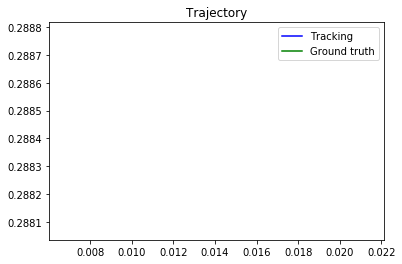

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


479 features left after pose estimation.
act scale 0.20526173024270541


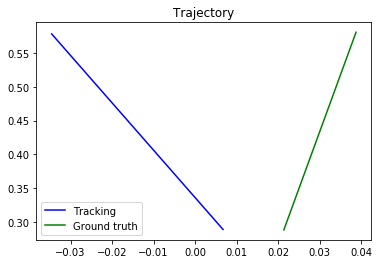

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


612 features left after pose estimation.
act scale 0.37297612552656356


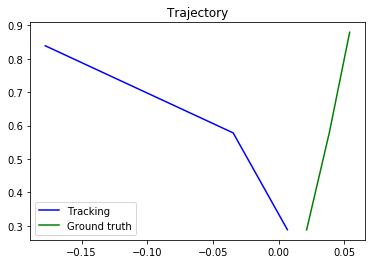

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


716 features left after pose estimation.
act scale 0.2505346408400168


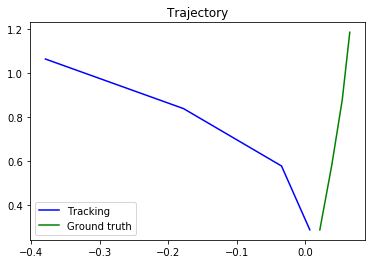

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


718 features left after pose estimation.
act scale 0.290647696119683


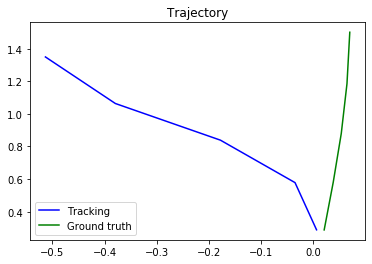

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


674 features left after pose estimation.
act scale 1.4767024305475436


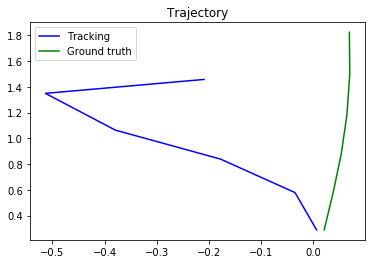

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


654 features left after pose estimation.
act scale 1.6418007377595587


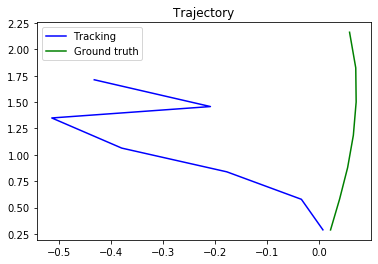

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


602 features left after pose estimation.
act scale 0.5971422263269838


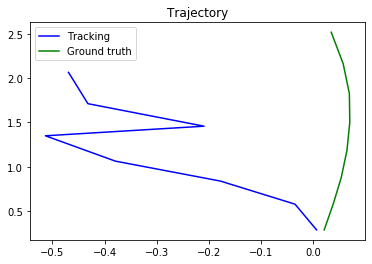

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


639 features left after pose estimation.
act scale 0.04333284137454263


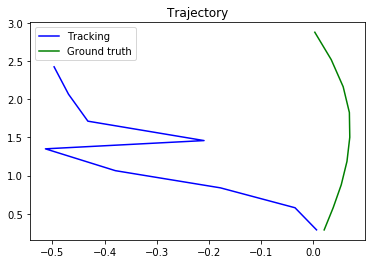

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


684 features left after pose estimation.
act scale 0.05183143411569215


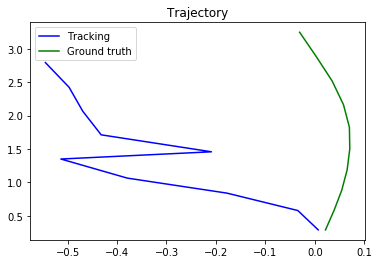

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


598 features left after pose estimation.
act scale 0.11661088535128561


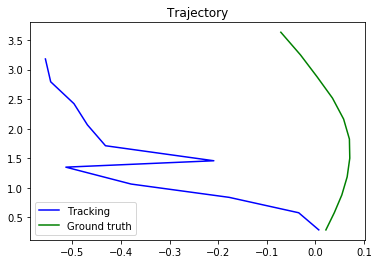

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


729 features left after pose estimation.
act scale 0.06616256521045769


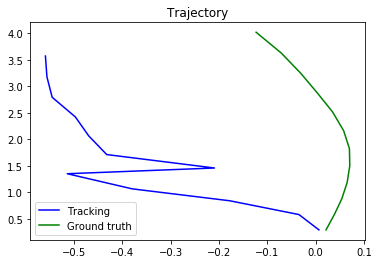

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


665 features left after pose estimation.
act scale 0.07665161787390545


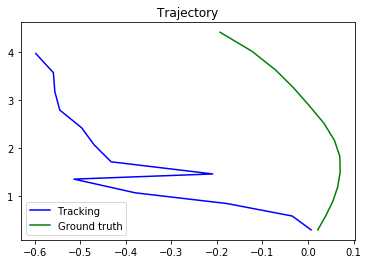

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


642 features left after pose estimation.
act scale 0.09632541745018988


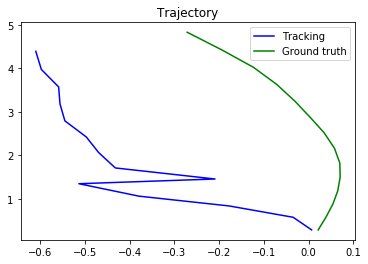

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


598 features left after pose estimation.
act scale 0.11132873292459723


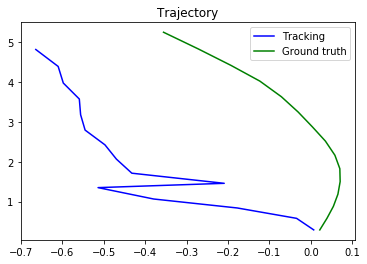

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


584 features left after pose estimation.
act scale 0.11018569250121976


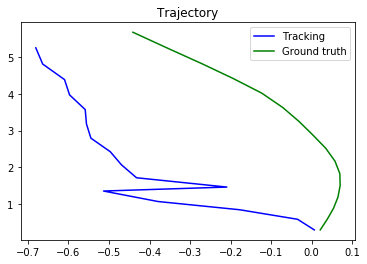

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


534 features left after pose estimation.
act scale 0.10076875334701699


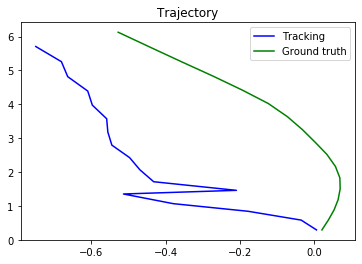

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


512 features left after pose estimation.
act scale 0.08544231192196085


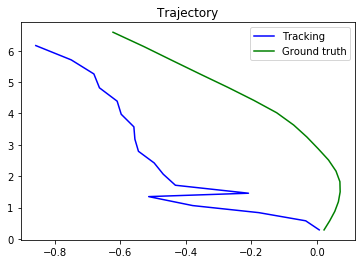

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


571 features left after pose estimation.
act scale 0.12517545284928686


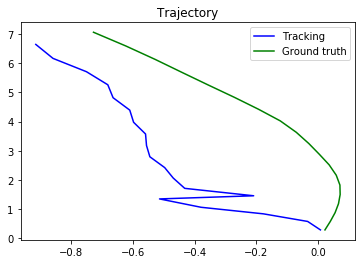

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


574 features left after pose estimation.
act scale 0.03529200007221961


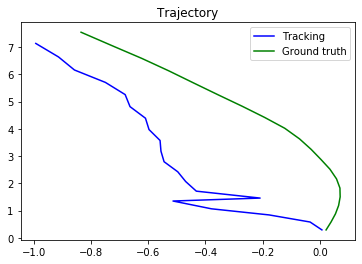

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


505 features left after pose estimation.
act scale 0.04429796692395072


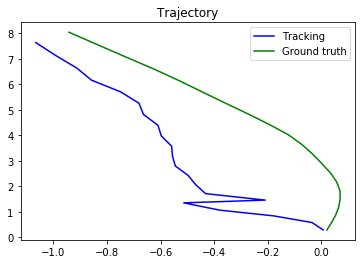

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


477 features left after pose estimation.
act scale 0.05697112910892564


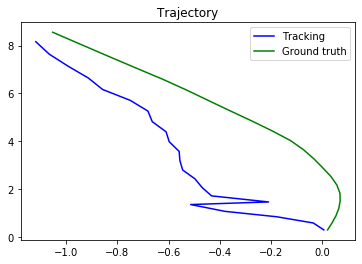

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


536 features left after pose estimation.
act scale 0.04666472482487838


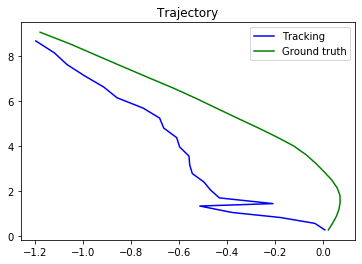

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


440 features left after pose estimation.
act scale 0.017468939598360142


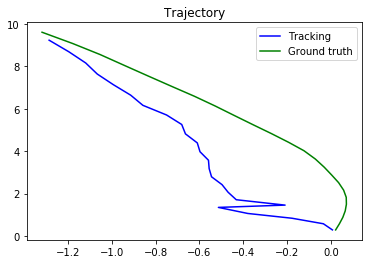

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


517 features left after pose estimation.
act scale 0.009351408172590425


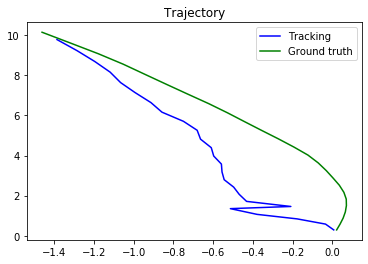

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


446 features left after pose estimation.
act scale 0.05455301540869684


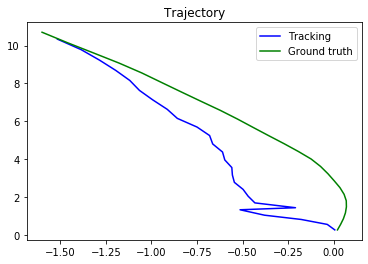

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


452 features left after pose estimation.
act scale 0.07080827804973808


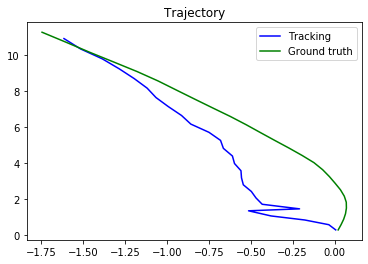

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


471 features left after pose estimation.
act scale 0.047847975775993264


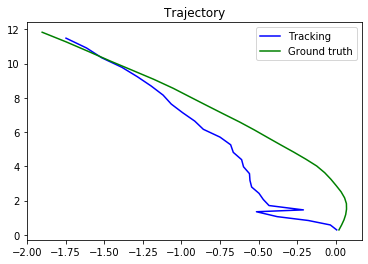

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


559 features left after pose estimation.
act scale 0.02904721336863066


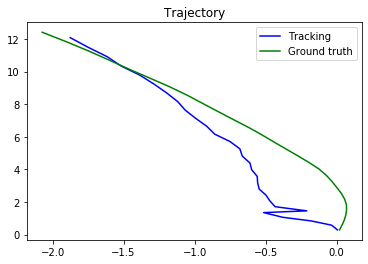

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


445 features left after pose estimation.
act scale 0.01681953840408664


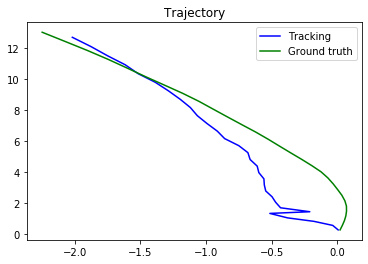

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


384 features left after pose estimation.
act scale 0.023540935144423788


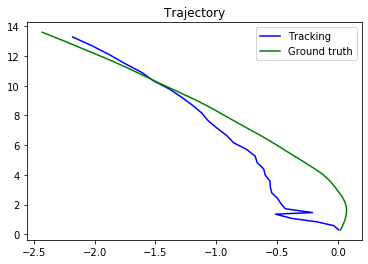

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


409 features left after pose estimation.
act scale 0.0454460925630411


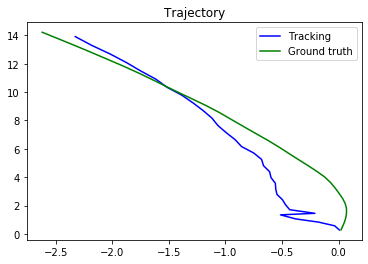

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


515 features left after pose estimation.
act scale 0.016934970520586932


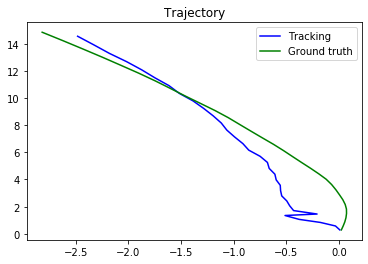

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


625 features left after pose estimation.
act scale 0.055978145122418194


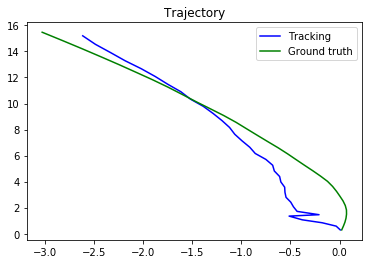

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


596 features left after pose estimation.
act scale 0.06334222880847706


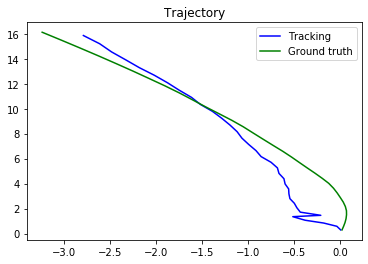

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


492 features left after pose estimation.
act scale 0.016346547672875782


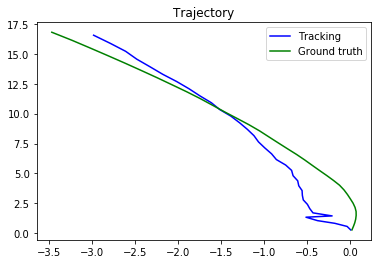

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


577 features left after pose estimation.
act scale 0.016042544101478068


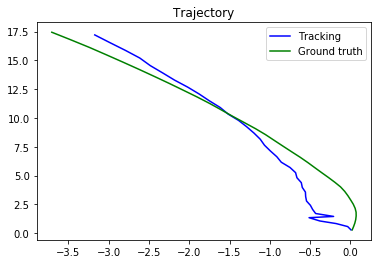

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


573 features left after pose estimation.
act scale 0.00588250459934106


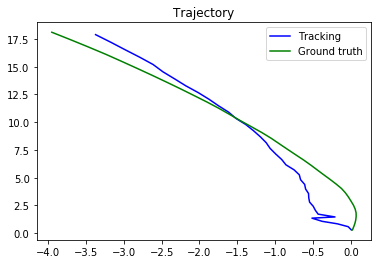

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


520 features left after pose estimation.
act scale 0.02372520825971707


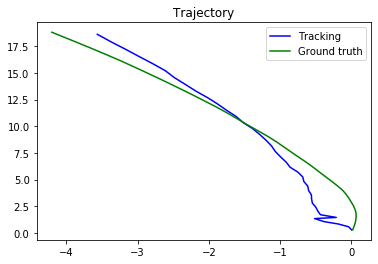

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


473 features left after pose estimation.
act scale 0.027946071139986237


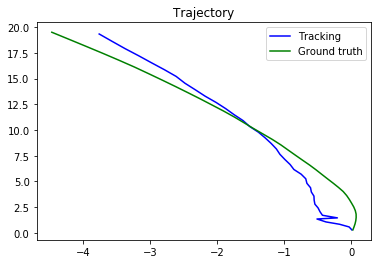

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


451 features left after pose estimation.
act scale 0.0374657160928156


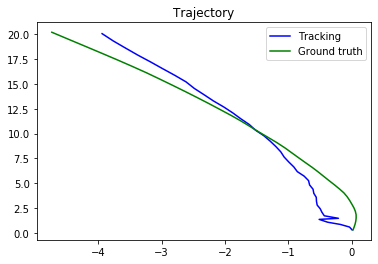

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


551 features left after pose estimation.
act scale 0.039126209994446506


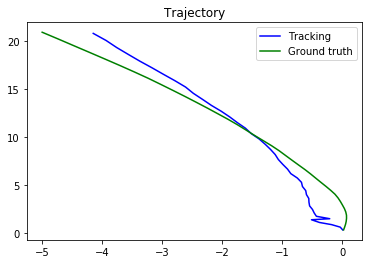

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


634 features left after pose estimation.
act scale 0.017617752233805656


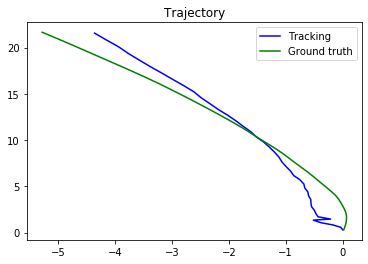

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


598 features left after pose estimation.
act scale 0.025423112579738127


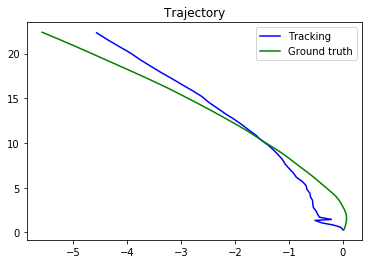

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


444 features left after pose estimation.
act scale 0.02650868414379728


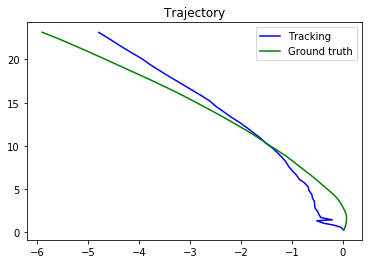

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


541 features left after pose estimation.
act scale 0.06034220577080984


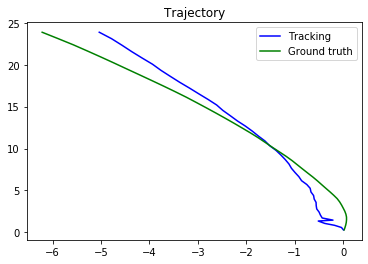

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


684 features left after pose estimation.
act scale 0.014157226453155505


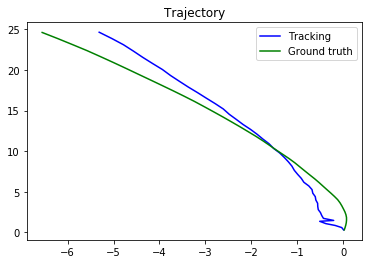

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


602 features left after pose estimation.
act scale 0.0056216073924291515


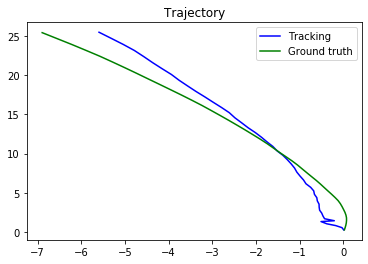

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


545 features left after pose estimation.
act scale 0.041517072811759974


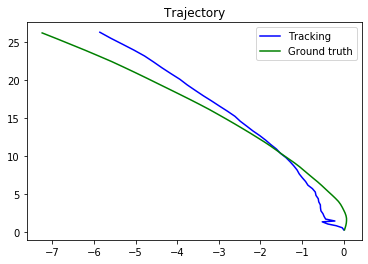

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


720 features left after pose estimation.
act scale 0.022160149840408292


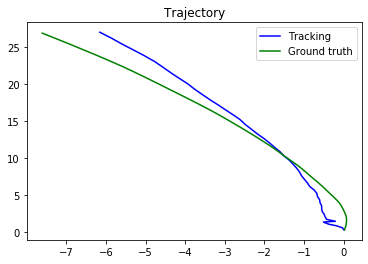

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


869 features left after pose estimation.
act scale 0.01510993144293726


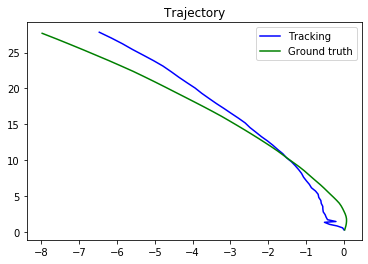

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


762 features left after pose estimation.
act scale 0.019437115473666246


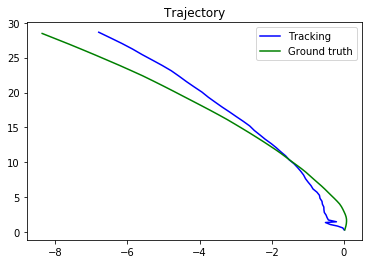

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


663 features left after pose estimation.
act scale 0.02258293027364938


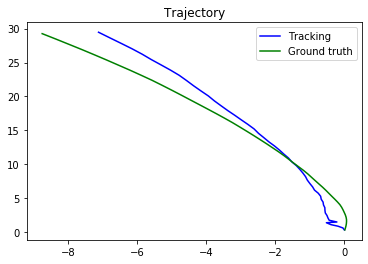

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


494 features left after pose estimation.
act scale 0.008843315241952365


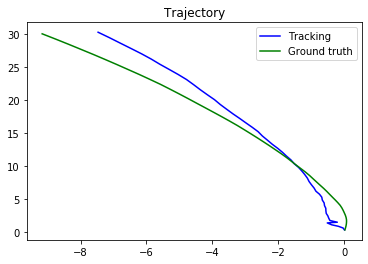

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


554 features left after pose estimation.
act scale 0.015651111017325848


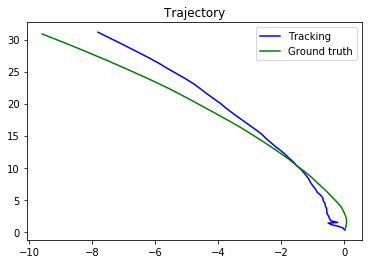

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


473 features left after pose estimation.
act scale 0.021120766452759617


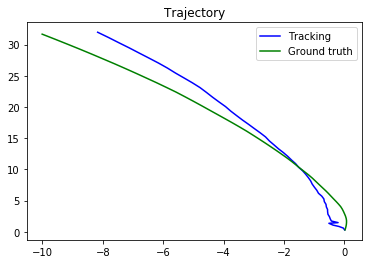

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


463 features left after pose estimation.
act scale 0.029749373870000793


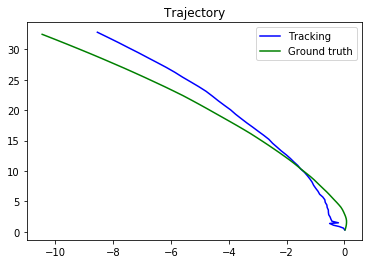

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


560 features left after pose estimation.
act scale 0.02070903012912314


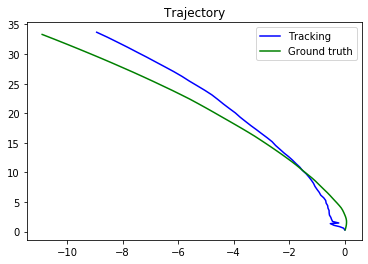

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


571 features left after pose estimation.
act scale 0.016364387730599467


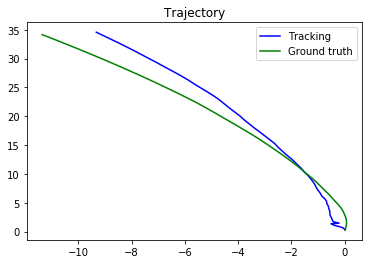

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


491 features left after pose estimation.
act scale 0.009910818517097433


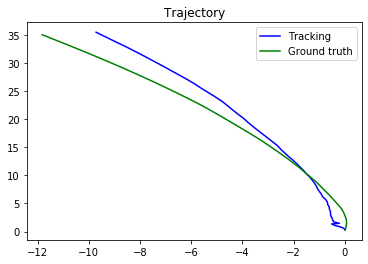

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


477 features left after pose estimation.
act scale 0.04266423283202246


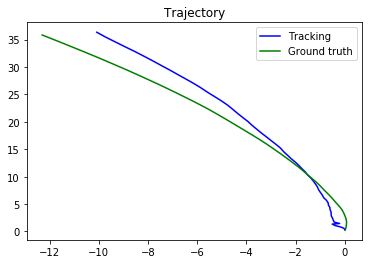

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


536 features left after pose estimation.
act scale 0.026677726469518437


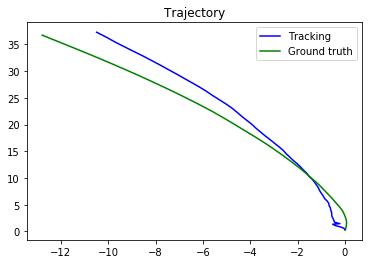

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


492 features left after pose estimation.
act scale 0.046985129945873075


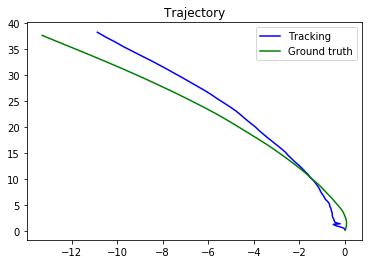

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


488 features left after pose estimation.
act scale 0.08035050426611144


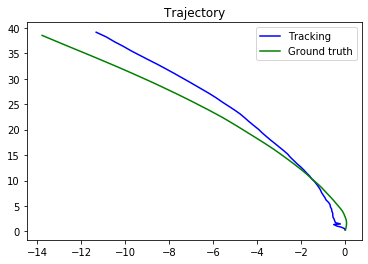

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


457 features left after pose estimation.
act scale 0.024870757286912435


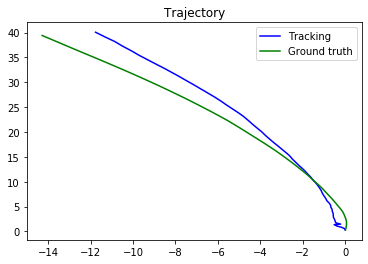

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


419 features left after pose estimation.
act scale 0.05417258748113379


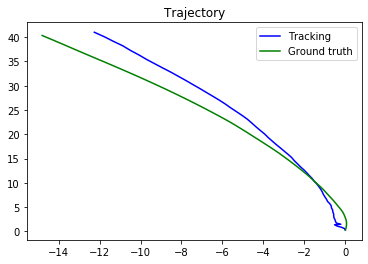

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


526 features left after pose estimation.
act scale 0.04876026183246786


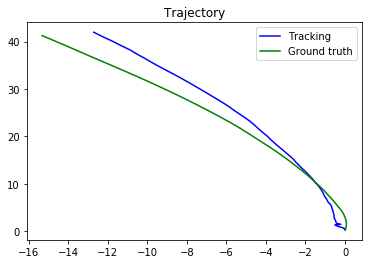

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


437 features left after pose estimation.
act scale 0.026779446024590568


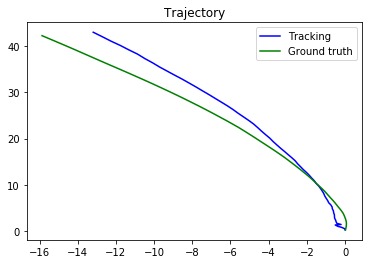

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


336 features left after pose estimation.
act scale 0.03369234069646856


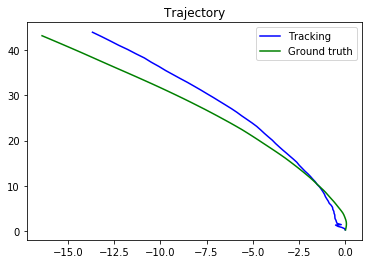

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


403 features left after pose estimation.
act scale 0.023478699373823735


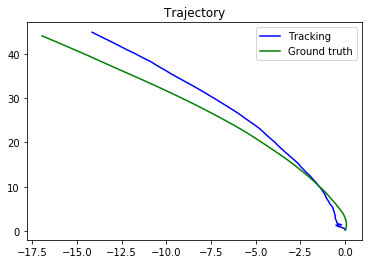

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


398 features left after pose estimation.
act scale 0.06820215126861719


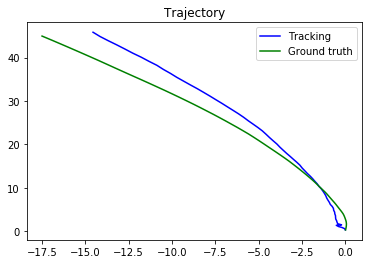

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


304 features left after pose estimation.
act scale 0.052665181550015164


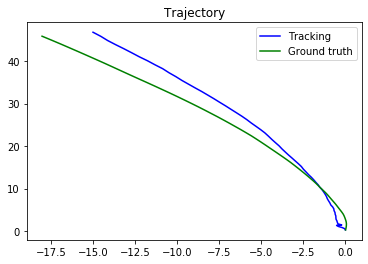

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


361 features left after pose estimation.
act scale 0.021127007179931236


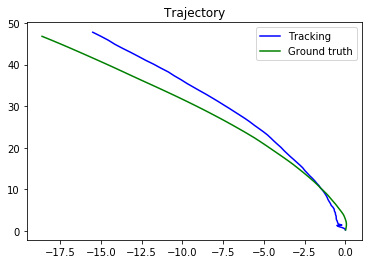

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


314 features left after pose estimation.
act scale 0.007657653400785522


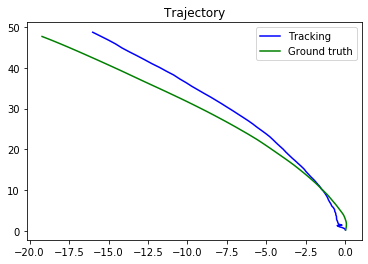

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


258 features left after pose estimation.
act scale 0.021751620561750364


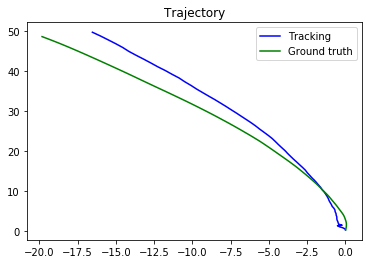

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


391 features left after pose estimation.
act scale 0.010418468072605358


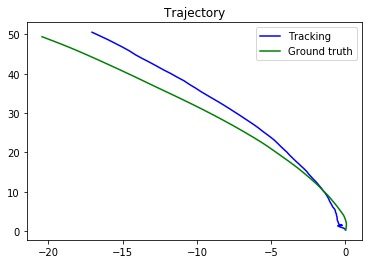

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


351 features left after pose estimation.
act scale 0.02361160615046854


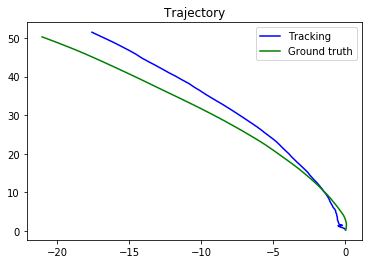

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


297 features left after pose estimation.
act scale 0.022812633196795384


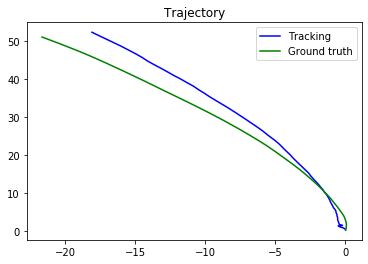

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


343 features left after pose estimation.
act scale 0.019571486417462768


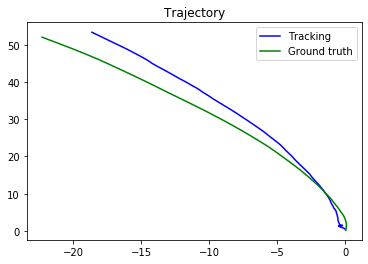

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


379 features left after pose estimation.
act scale 0.02888341163314033


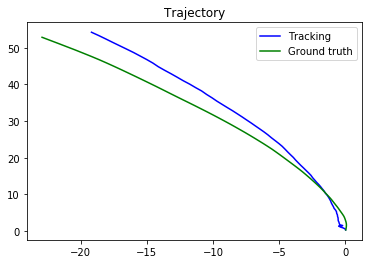

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


259 features left after pose estimation.
act scale 0.7147016478331775


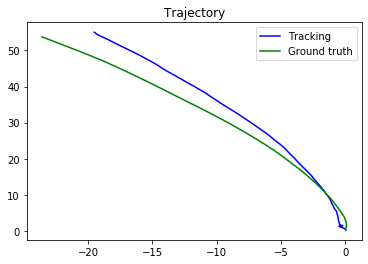

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


424 features left after pose estimation.
act scale 0.7024576859857453


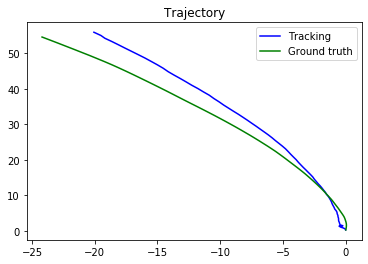

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


474 features left after pose estimation.
act scale 0.011169701489128778


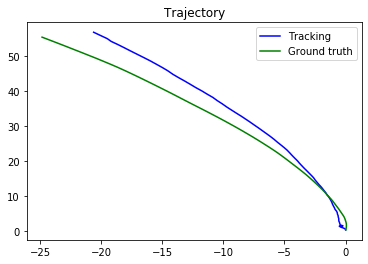

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


421 features left after pose estimation.
act scale 0.02530196078217672


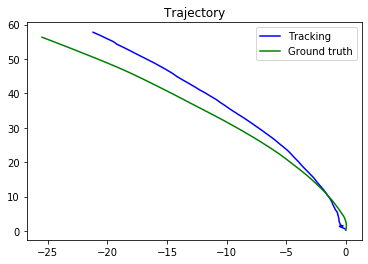

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


383 features left after pose estimation.
act scale 0.03579275484780371


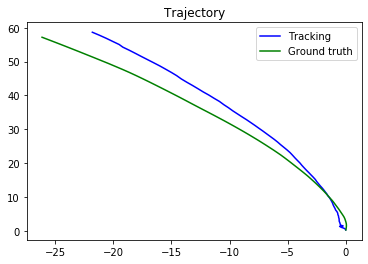

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


473 features left after pose estimation.
act scale 0.009662186480173744


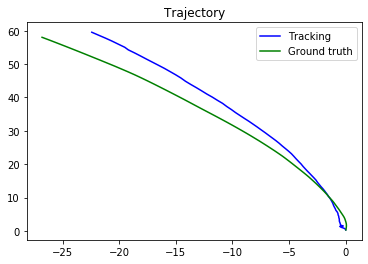

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


525 features left after pose estimation.
act scale 0.011193118220682367


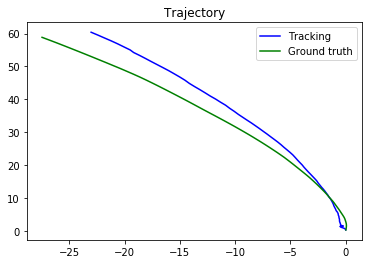

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


452 features left after pose estimation.
act scale 0.0408930683291087


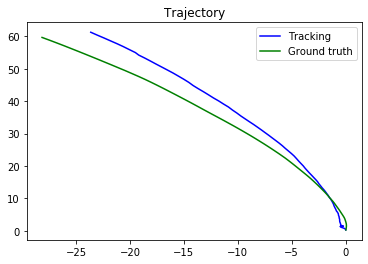

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


562 features left after pose estimation.
act scale 0.025786492407958644


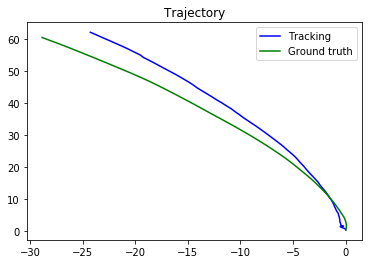

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


581 features left after pose estimation.
act scale 0.02282312373727987


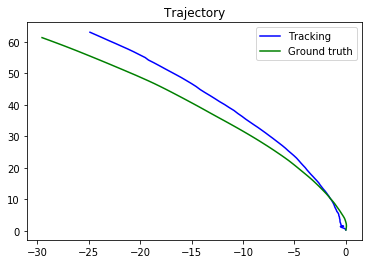

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


591 features left after pose estimation.
act scale 0.01692627479632778


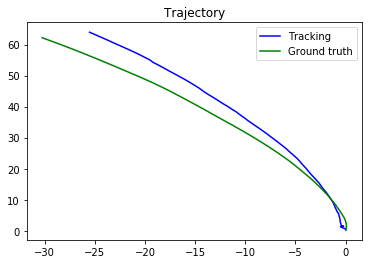

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


598 features left after pose estimation.
act scale 0.03397251328692974


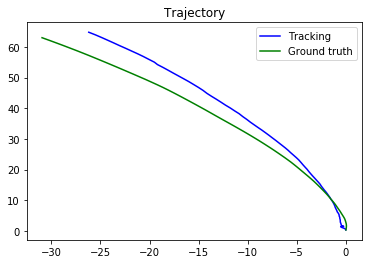

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


667 features left after pose estimation.
act scale 0.04941410203527939


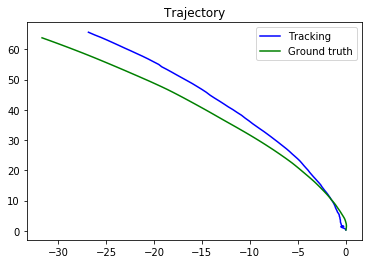

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


640 features left after pose estimation.
act scale 0.009732654912775363


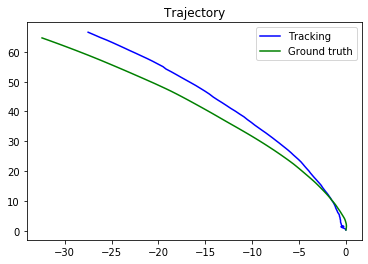

573 features left after pose estimation.
act scale 0.01219080829638166


/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


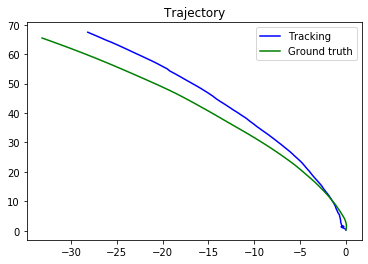

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


389 features left after pose estimation.
act scale 0.022213157957939756


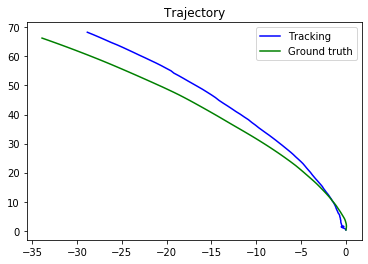

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


403 features left after pose estimation.
act scale 0.024939258645235392


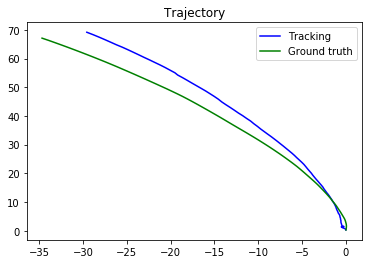

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


385 features left after pose estimation.
act scale 0.03137882405070943


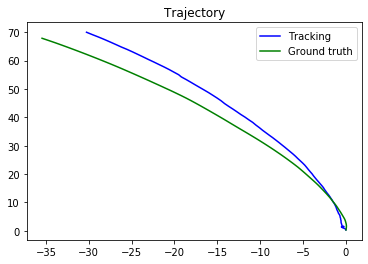

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


350 features left after pose estimation.
act scale 0.0013851834772856467


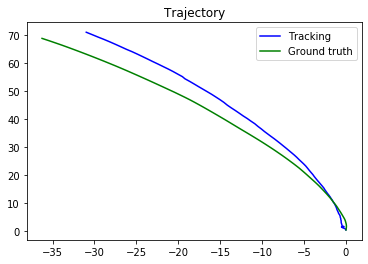

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


356 features left after pose estimation.
act scale 0.053983310989855975


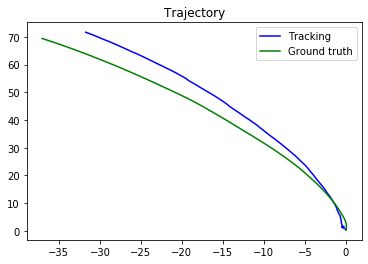

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


373 features left after pose estimation.
act scale 0.03960534446102525


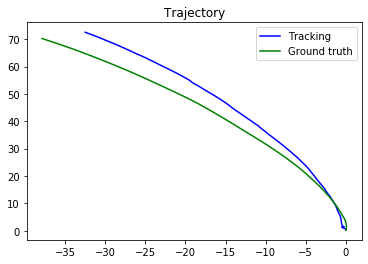

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


441 features left after pose estimation.
act scale 0.03925399860123123


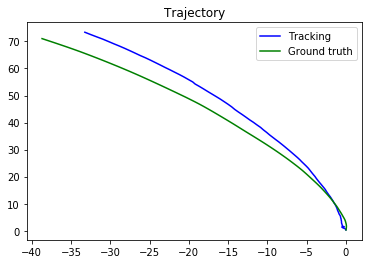

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


463 features left after pose estimation.
act scale 0.01674016437886012


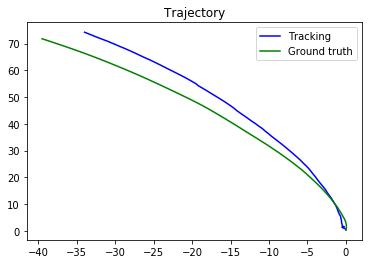

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


387 features left after pose estimation.
act scale 0.02275732258719234


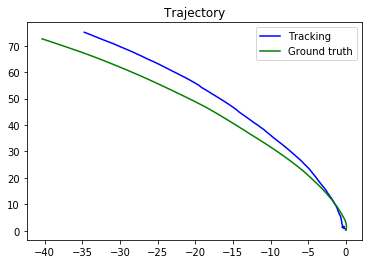

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


527 features left after pose estimation.
act scale 0.011562432194038352


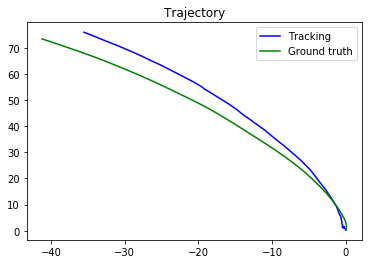

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


494 features left after pose estimation.
act scale 0.012024564451406133


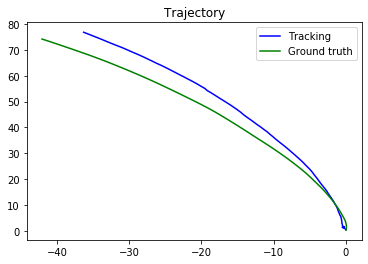

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


370 features left after pose estimation.
act scale 0.02371796704200021


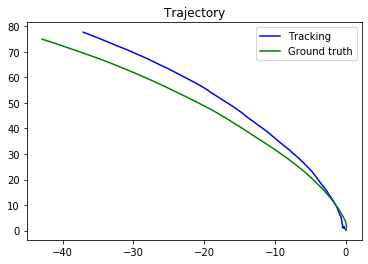

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


458 features left after pose estimation.
act scale 0.027724325853529817


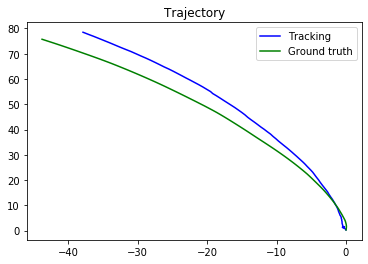

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


483 features left after pose estimation.
act scale 0.034065034768834844


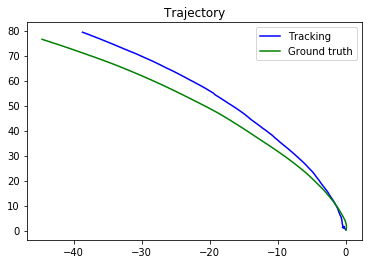

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


515 features left after pose estimation.
act scale 0.040259452882026134


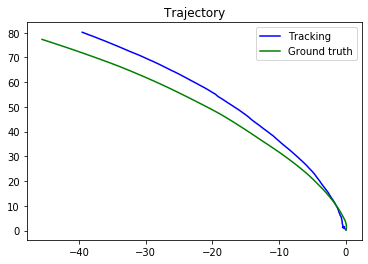

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


599 features left after pose estimation.
act scale 0.015946588402740484


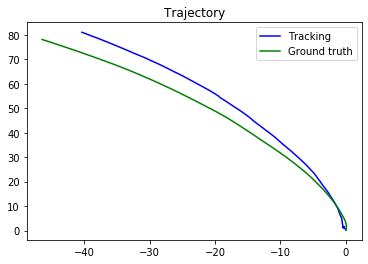

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


605 features left after pose estimation.
act scale 0.017089453288803524


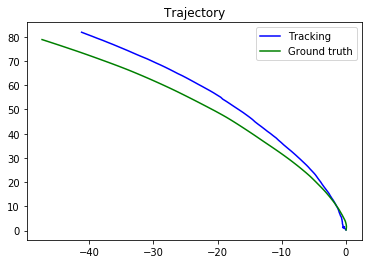

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


588 features left after pose estimation.
act scale 0.0077665421986308535


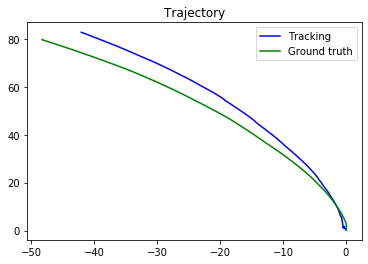

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


517 features left after pose estimation.
act scale 0.024844464850524904


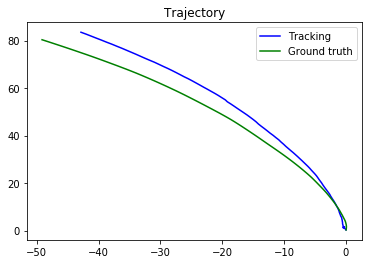

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


591 features left after pose estimation.
act scale 0.02272071146000104


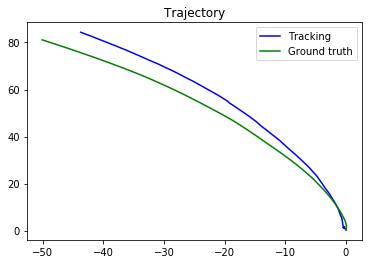

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


614 features left after pose estimation.
act scale 0.016869635159179573


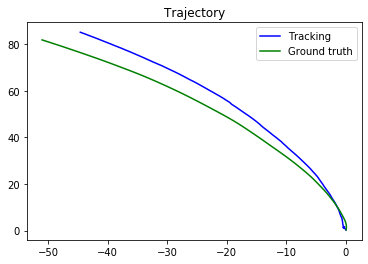

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


620 features left after pose estimation.
act scale 0.007393476815733968


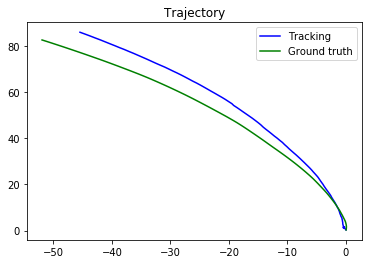

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


570 features left after pose estimation.
act scale 0.013491226412587331


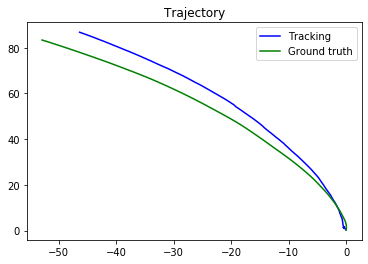

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


508 features left after pose estimation.
act scale 0.042058600987919845


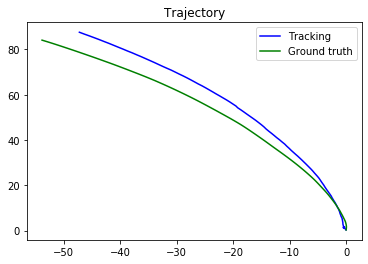

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


603 features left after pose estimation.
act scale 0.04872910859054188


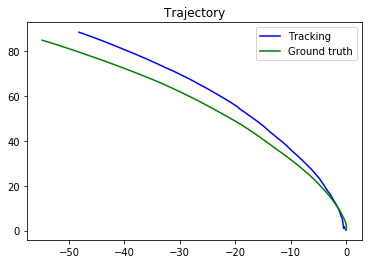

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


603 features left after pose estimation.
act scale 0.03764625606475288


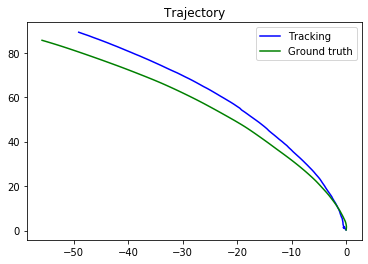

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


634 features left after pose estimation.
act scale 0.0323687916640841


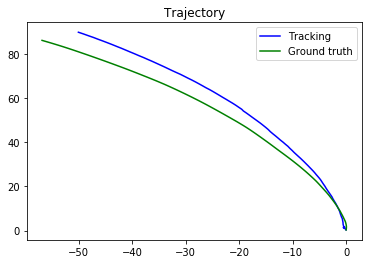

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


708 features left after pose estimation.
act scale 0.06215700697317216


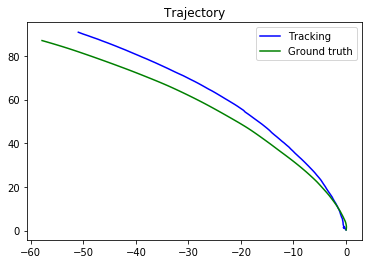

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


700 features left after pose estimation.
act scale 0.04841250382242296


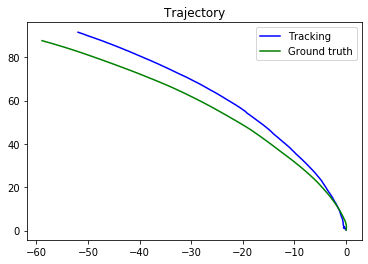

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


598 features left after pose estimation.
act scale 0.00974546847375689


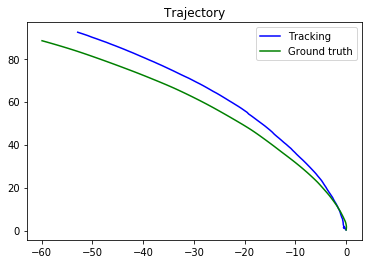

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


700 features left after pose estimation.
act scale 0.02915131560582062


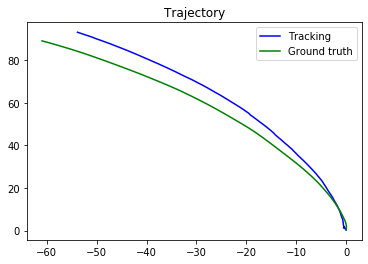

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


705 features left after pose estimation.
act scale 0.047679194477533535


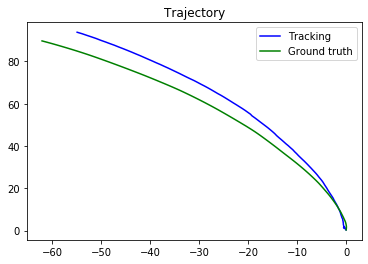

718 features left after pose estimation.
act scale 0.02128982015888708


/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


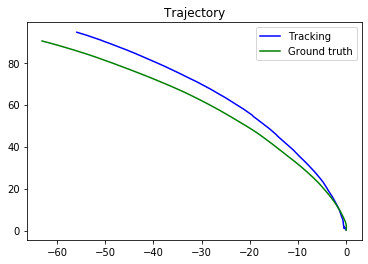

768 features left after pose estimation.
act scale 0.017682988934169572


/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


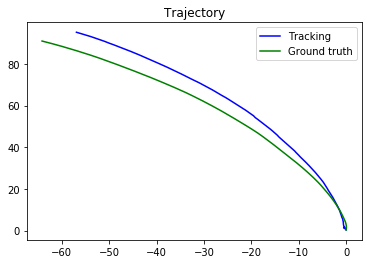

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


763 features left after pose estimation.
act scale 0.020817731607117605


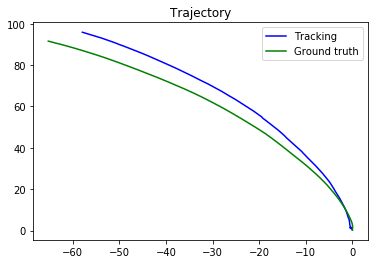

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


518 features left after pose estimation.
act scale 0.026721183899711568


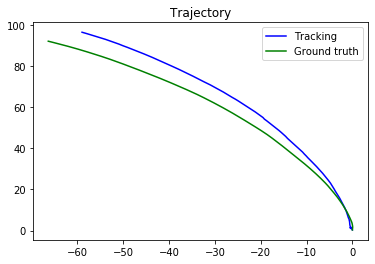

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


573 features left after pose estimation.
act scale 0.027775081546314268


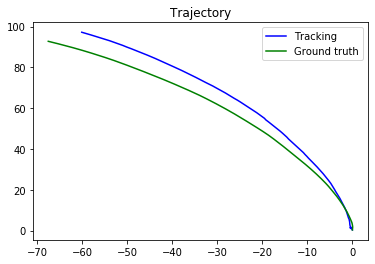

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


556 features left after pose estimation.
act scale 0.01463203720273122


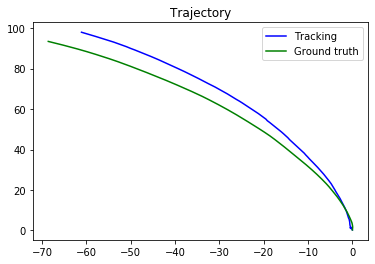

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


440 features left after pose estimation.
act scale 0.01151691967488434


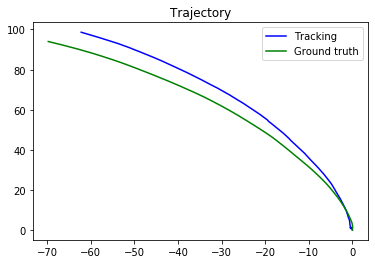

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


477 features left after pose estimation.
act scale 0.009975589735576855


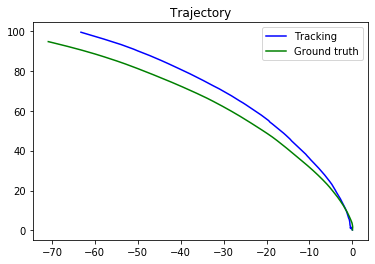

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


580 features left after pose estimation.
act scale 0.017551119760005403


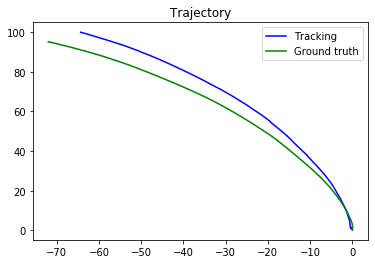

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


611 features left after pose estimation.
act scale 0.025988839283825824


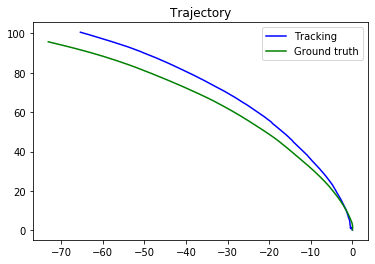

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


414 features left after pose estimation.
act scale 0.036854905076863155


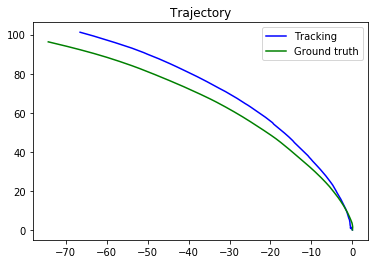

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


291 features left after pose estimation.
act scale 0.011436393618948175


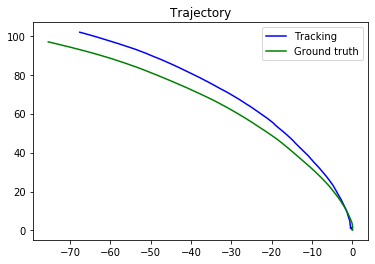

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


413 features left after pose estimation.
act scale 0.048935897639272634


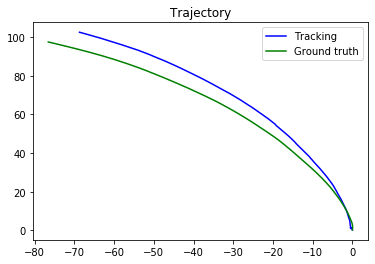

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


413 features left after pose estimation.
act scale 0.01472384458734076


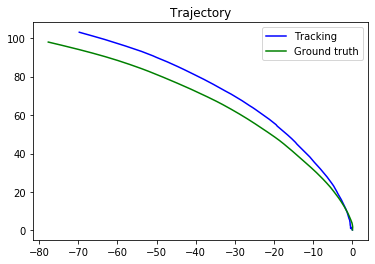

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


398 features left after pose estimation.
act scale 0.028513356858495795


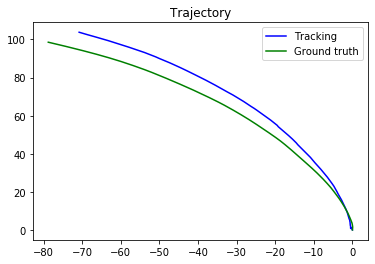

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


482 features left after pose estimation.
act scale 0.029458584323543653


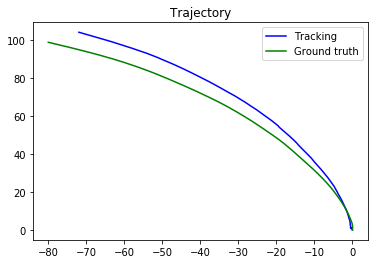

587 features left after pose estimation.
act scale 0.013744654669441194


/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


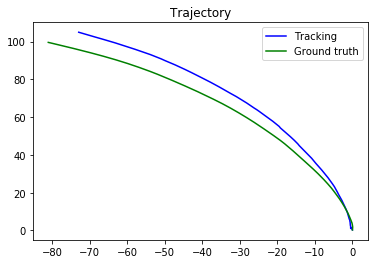

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


454 features left after pose estimation.
act scale 0.03171519832783178


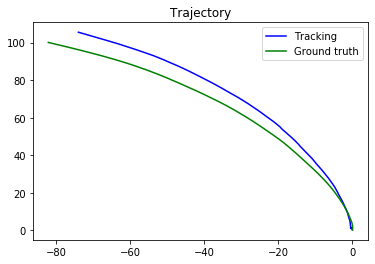

488 features left after pose estimation.
act scale 0.020992303342019295


/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


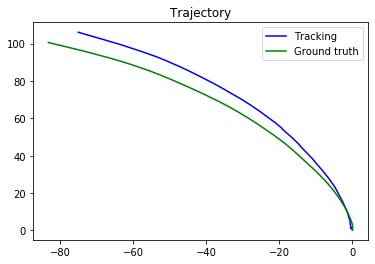

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


401 features left after pose estimation.
act scale 0.0204964002434184


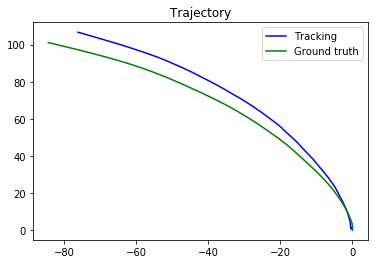

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


427 features left after pose estimation.
act scale 0.029689197045611387


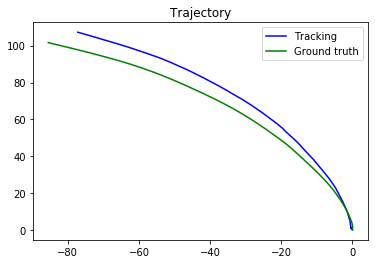

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


426 features left after pose estimation.
act scale 0.012594402478753496


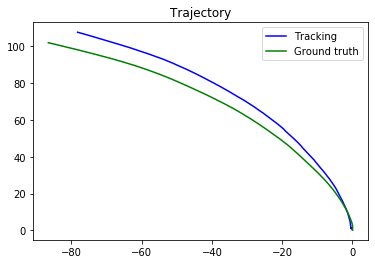

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


399 features left after pose estimation.
act scale 0.019530277555444984


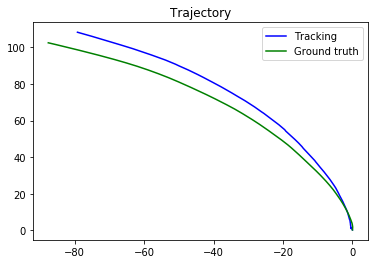

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


470 features left after pose estimation.
act scale 0.006355405590808231


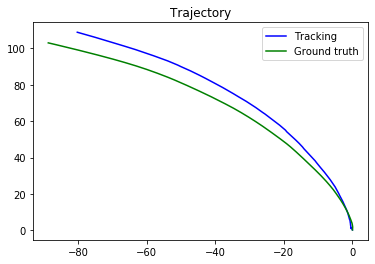

519 features left after pose estimation.
act scale 0.03500252034031282


/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


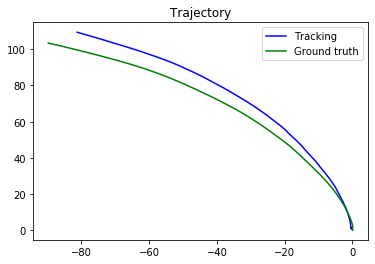

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


509 features left after pose estimation.
act scale 0.01258631689132891


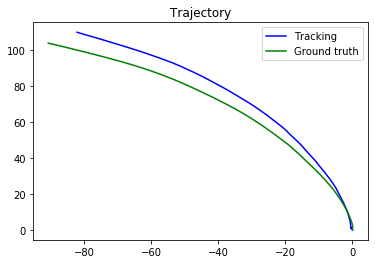

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


483 features left after pose estimation.
act scale 0.015878188101204064


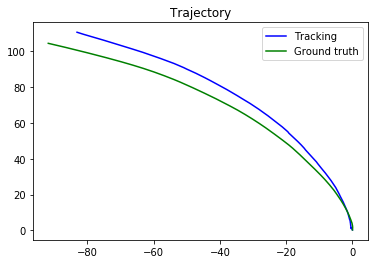

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


471 features left after pose estimation.
act scale 0.0185531450768487


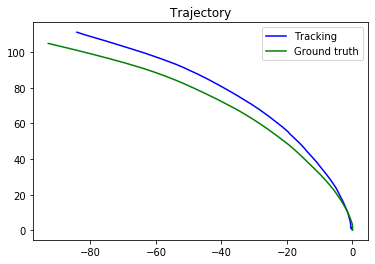

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


537 features left after pose estimation.
act scale 0.021784586101241787


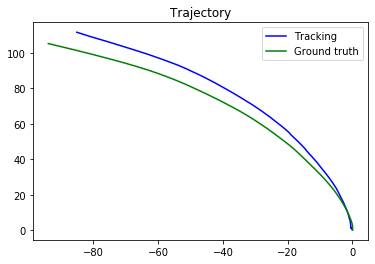

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


535 features left after pose estimation.
act scale 0.010139002361553025


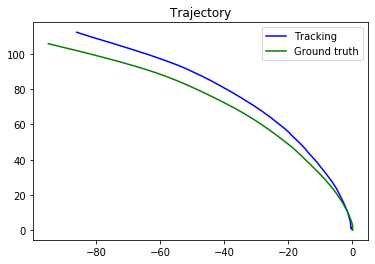

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


513 features left after pose estimation.
act scale 0.07003973516052878


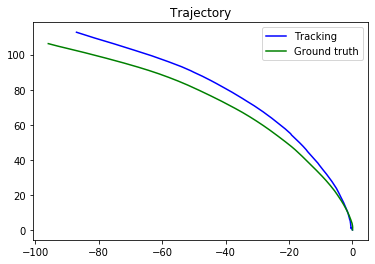

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


526 features left after pose estimation.
act scale 0.03514950197109022


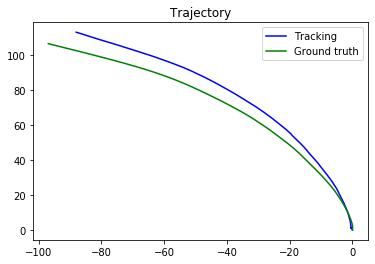

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


544 features left after pose estimation.
act scale 0.055747710102854724


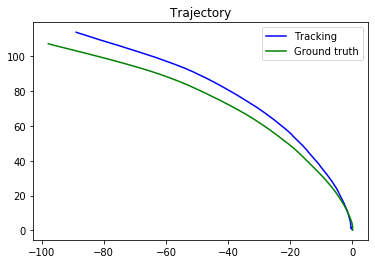

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


517 features left after pose estimation.
act scale 0.04091460695995744


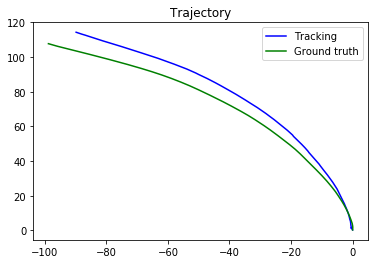

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


412 features left after pose estimation.
act scale 0.03264907090242053


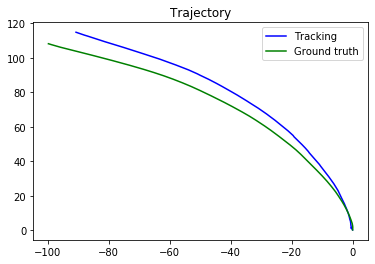

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


437 features left after pose estimation.
act scale 0.021621835043005445


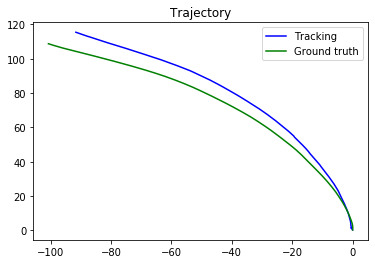

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


427 features left after pose estimation.
act scale 0.016941211687122815


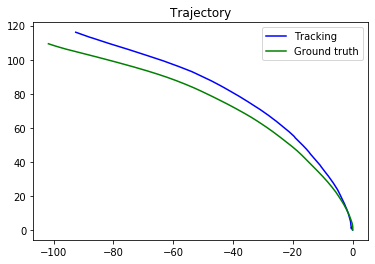

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


384 features left after pose estimation.
act scale 0.012983956556717764


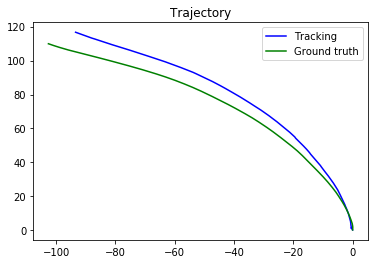

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


466 features left after pose estimation.
act scale 0.01707743828709829


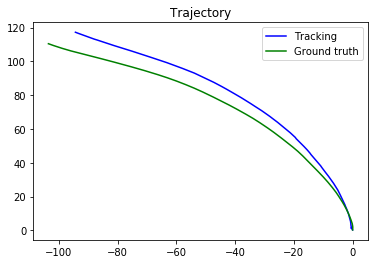

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


449 features left after pose estimation.
act scale 0.005755334493238336


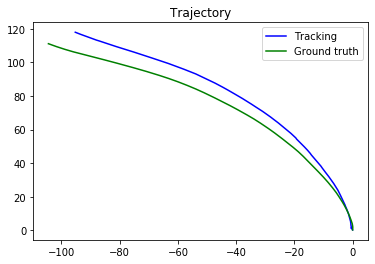

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


418 features left after pose estimation.
act scale 0.010714802573707731


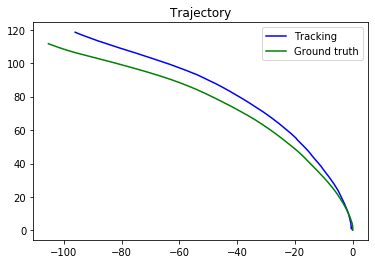

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


433 features left after pose estimation.
act scale 0.025680992234699034


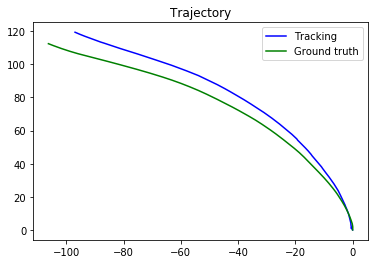

518 features left after pose estimation.
act scale 0.013616458949300643


/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


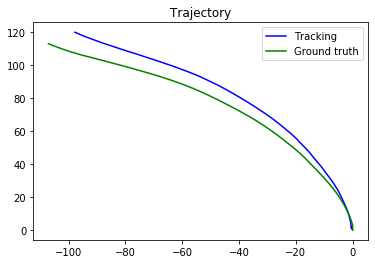

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


456 features left after pose estimation.
act scale 0.02613540475508337


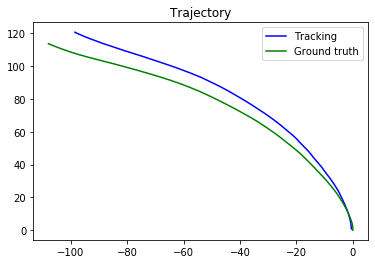

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


418 features left after pose estimation.
act scale 0.030246007740053756


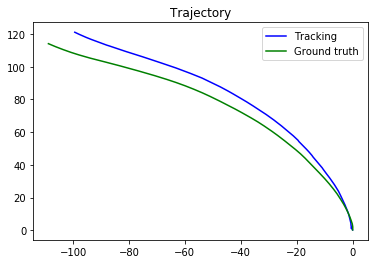

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


385 features left after pose estimation.
act scale 0.02801932026303057


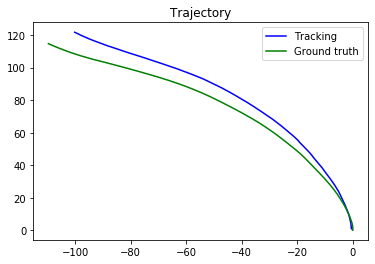

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


383 features left after pose estimation.
act scale 0.03334177138047475


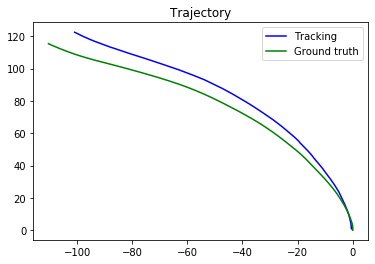

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


320 features left after pose estimation.
act scale 0.04803418057520648


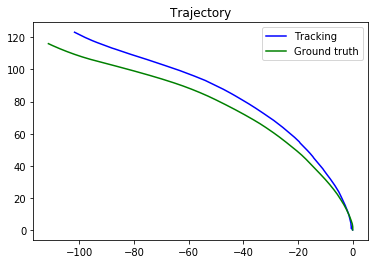

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


363 features left after pose estimation.
act scale 0.04259760296060133


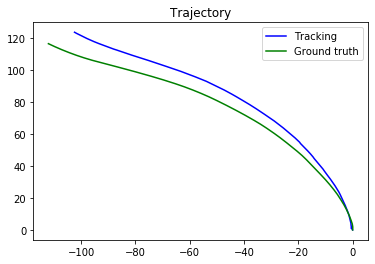

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


391 features left after pose estimation.
act scale 0.04219046405044191


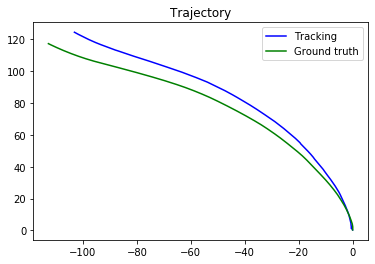

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


314 features left after pose estimation.
act scale 0.021098278256106856


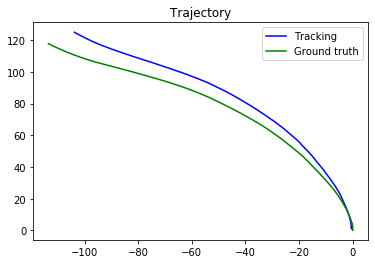

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


398 features left after pose estimation.
act scale 0.02058640723157276


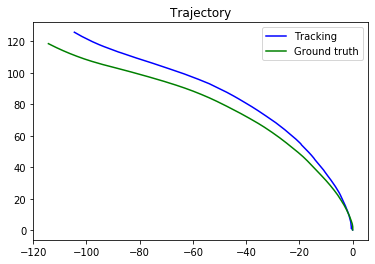

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


444 features left after pose estimation.
act scale 0.02167741866508392


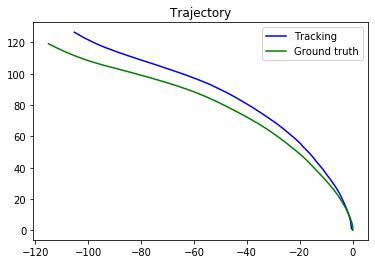

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


409 features left after pose estimation.
act scale 0.02216140105334845


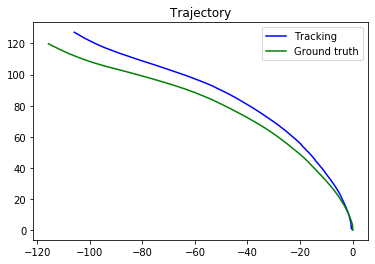

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


453 features left after pose estimation.
act scale 0.059895153371655636


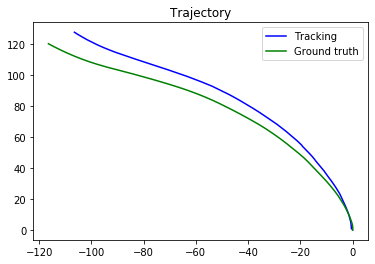

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


426 features left after pose estimation.
act scale 0.024102234859102137


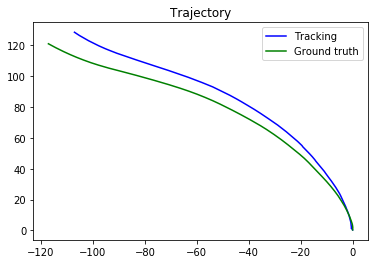

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


391 features left after pose estimation.
act scale 0.03241199871308763


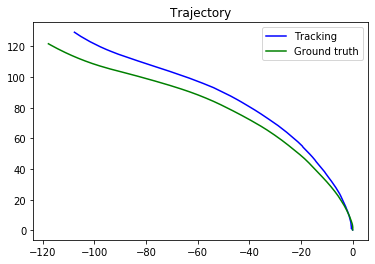

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


449 features left after pose estimation.
act scale 0.04426678016302111


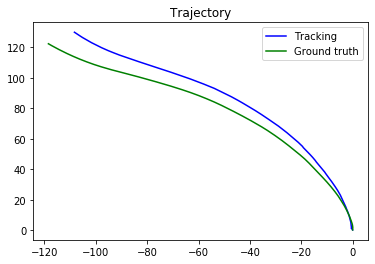

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


455 features left after pose estimation.
act scale 0.025453617413048222


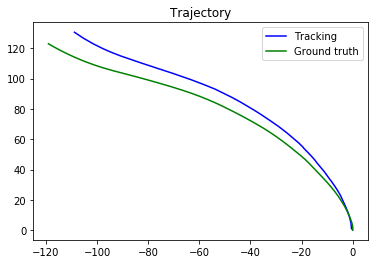

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


493 features left after pose estimation.
act scale 0.031810598118060224


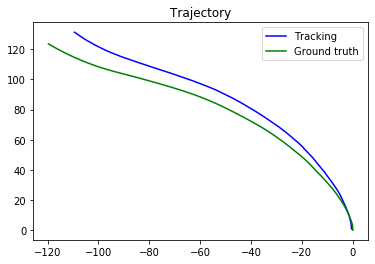

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


523 features left after pose estimation.
act scale 0.03500923717147149


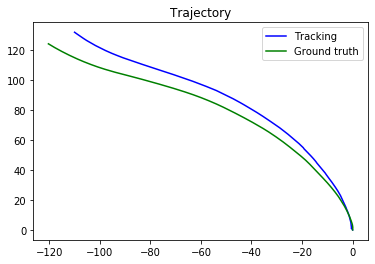

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


446 features left after pose estimation.
act scale 0.019111261887412762


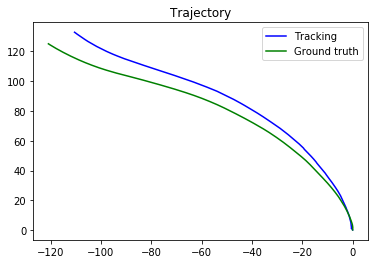

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


434 features left after pose estimation.
act scale 0.03949388990545735


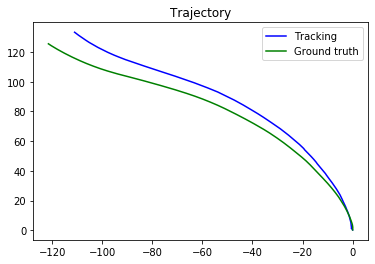

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


350 features left after pose estimation.
act scale 0.0036114135364107027


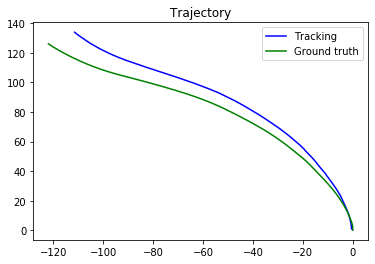

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


405 features left after pose estimation.
act scale 0.02437747543794708


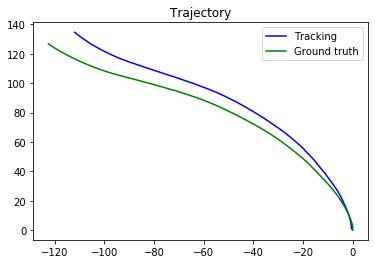

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


499 features left after pose estimation.
act scale 0.05928491128655549


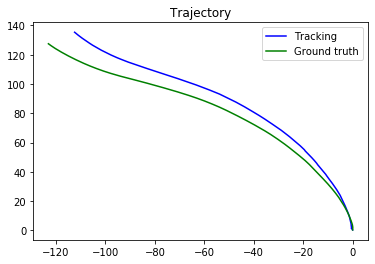

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


424 features left after pose estimation.
act scale 0.08773267701422463


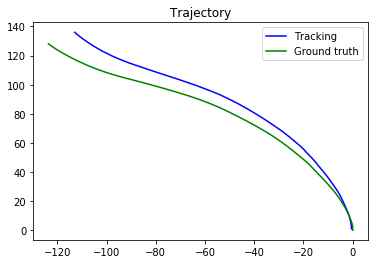

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


398 features left after pose estimation.
act scale 0.04220559136431276


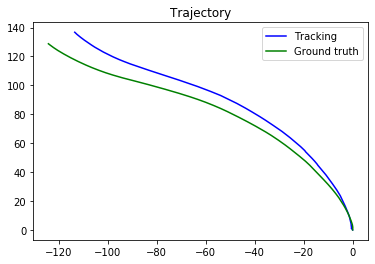

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


557 features left after pose estimation.
act scale 0.03954134815636951


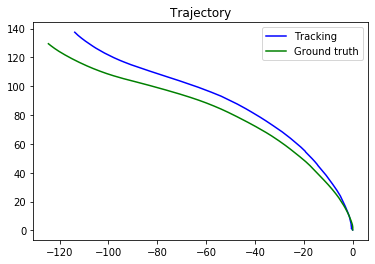

637 features left after pose estimation.
act scale 0.05664499327730555


/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


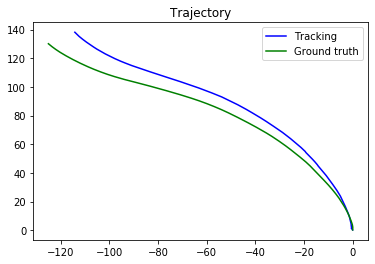

719 features left after pose estimation.
act scale 0.10580996270076548


/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


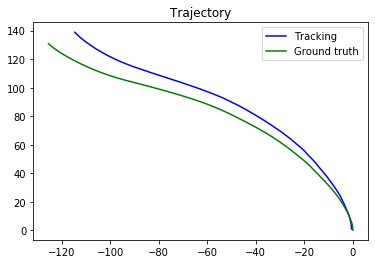

649 features left after pose estimation.
act scale 0.010704269388458514


/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


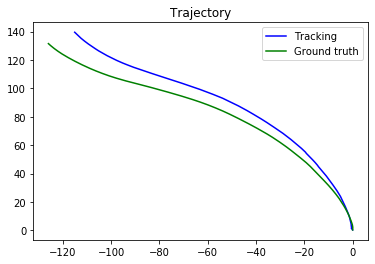

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


560 features left after pose estimation.
act scale 0.13774715752257422


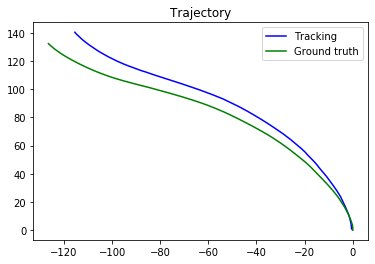

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


570 features left after pose estimation.
act scale 0.028721949965222395


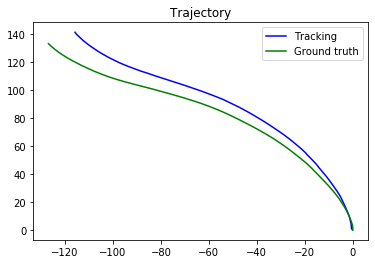

683 features left after pose estimation.
act scale 0.018448011375429757


/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


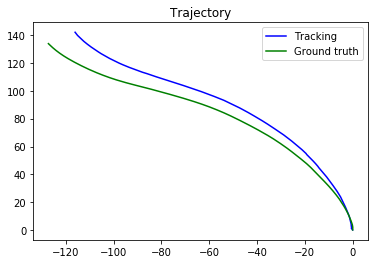

705 features left after pose estimation.
act scale 0.06093305254173267


/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


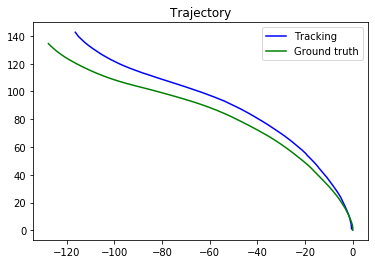

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


794 features left after pose estimation.
act scale 0.15223145395496038


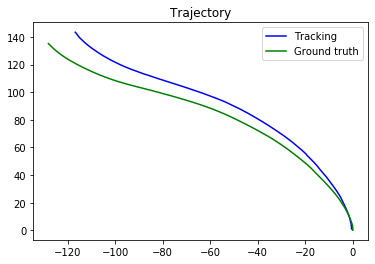

711 features left after pose estimation.
act scale 0.023575783929107506


/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


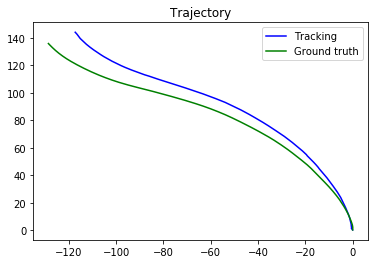

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


726 features left after pose estimation.
act scale 0.015180582742887432


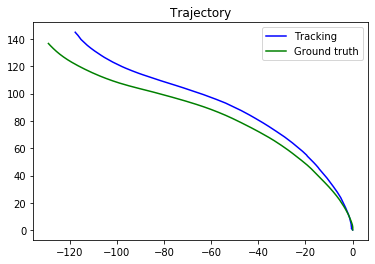

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


664 features left after pose estimation.
act scale 0.06351123911190494


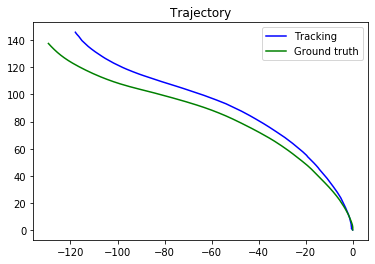

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


535 features left after pose estimation.
act scale 0.24353489511263907


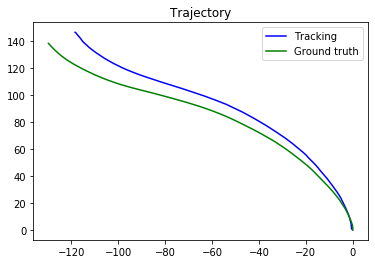

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


488 features left after pose estimation.
act scale 0.5369356448690041


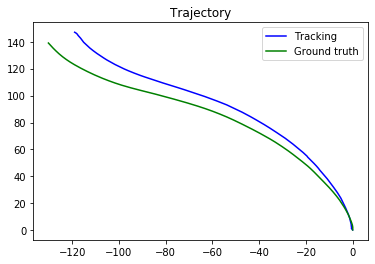

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


637 features left after pose estimation.
act scale 0.6449086154073803


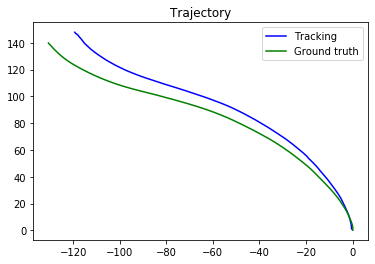

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


723 features left after pose estimation.
act scale 0.004355401936927008


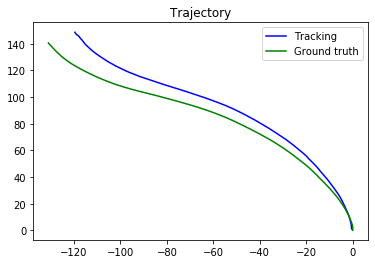

844 features left after pose estimation.
act scale 0.040675661017525844


/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


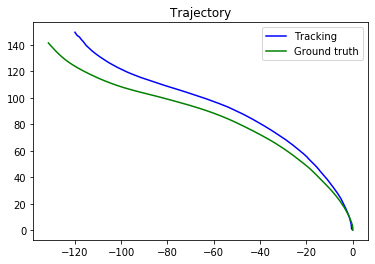

827 features left after pose estimation.
act scale 0.02748234885403329


/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


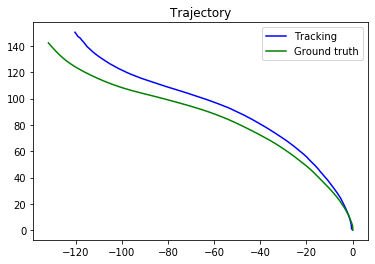

756 features left after pose estimation.
act scale 0.033111799026405465


/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


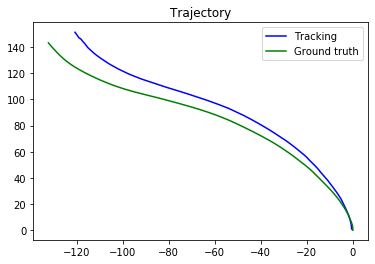

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


722 features left after pose estimation.
act scale 0.027665843642217944


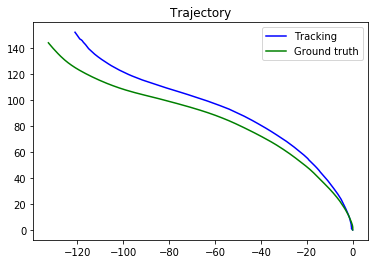

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


651 features left after pose estimation.
act scale 0.10263756520506413


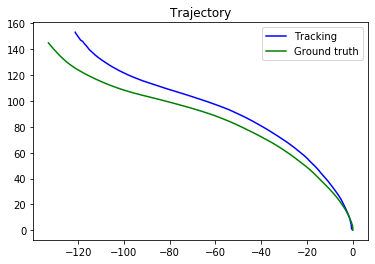

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


686 features left after pose estimation.
act scale 0.1331834089029071


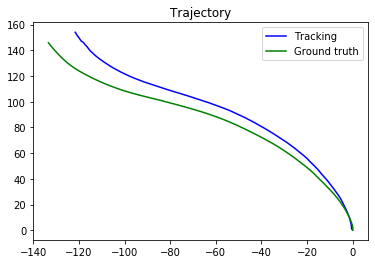

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


733 features left after pose estimation.
act scale 0.05300800666404781


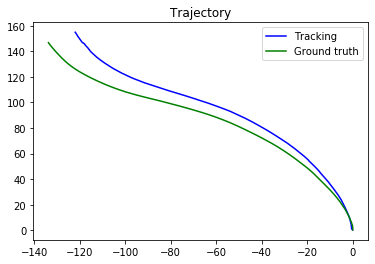

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


725 features left after pose estimation.
act scale 0.06232168318727702


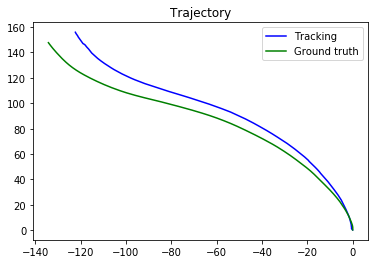

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


672 features left after pose estimation.
act scale 0.035368224428188606


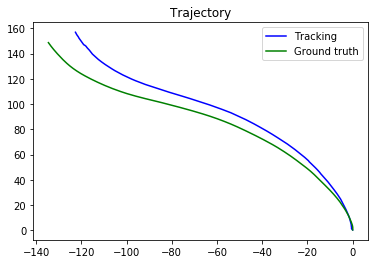

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


573 features left after pose estimation.
act scale 0.00550684315952345


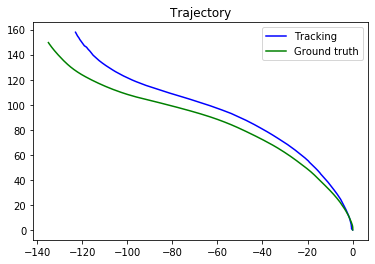

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


485 features left after pose estimation.
act scale 0.0958513821173254


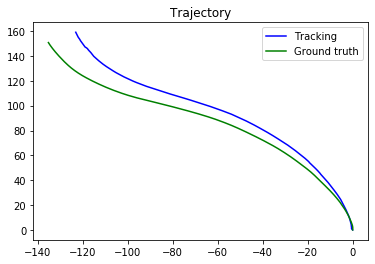

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


496 features left after pose estimation.
act scale 0.10997957514000914


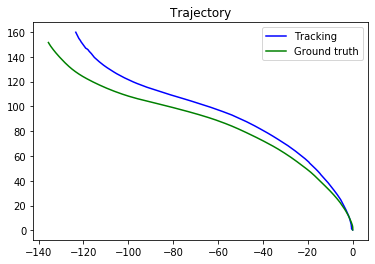

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


560 features left after pose estimation.
act scale 0.004349348030431143


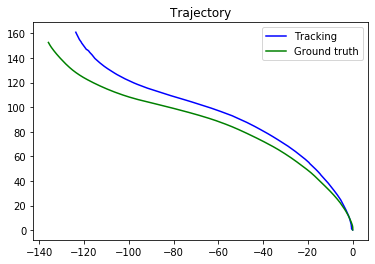

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


684 features left after pose estimation.
act scale 0.03475531349380213


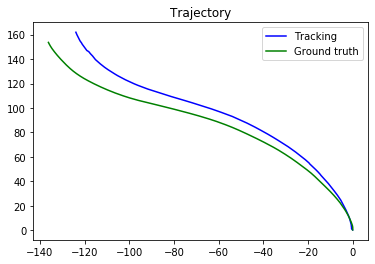

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


632 features left after pose estimation.
act scale 0.07027281172312738


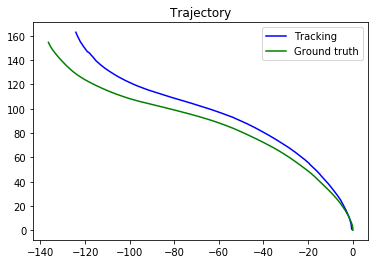

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


518 features left after pose estimation.
act scale 0.03452719434761694


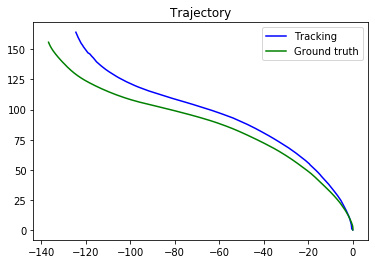

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


628 features left after pose estimation.
act scale 0.01323319163497397


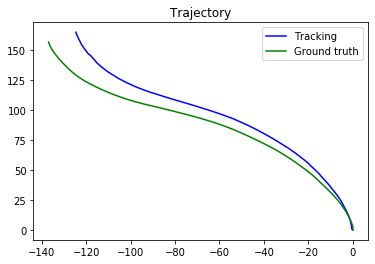

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


813 features left after pose estimation.
act scale 0.015122231060044506


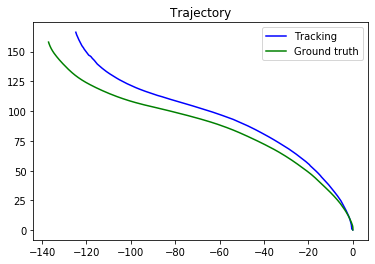

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


595 features left after pose estimation.
act scale 0.008249803757328764


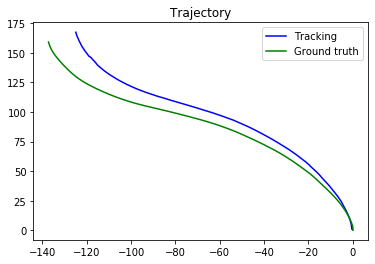

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


402 features left after pose estimation.
act scale 1.2599938582961583


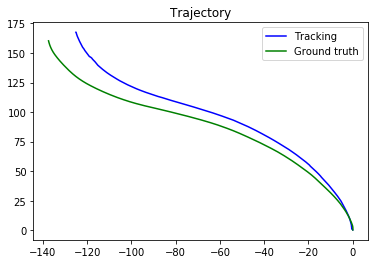

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


603 features left after pose estimation.
act scale 1.2571786963735232


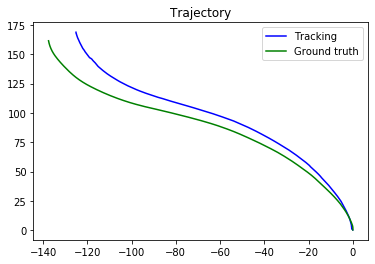

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


571 features left after pose estimation.
act scale 0.007137657311150901


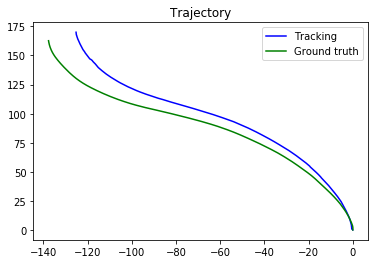

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


474 features left after pose estimation.
act scale 0.021623590132855783


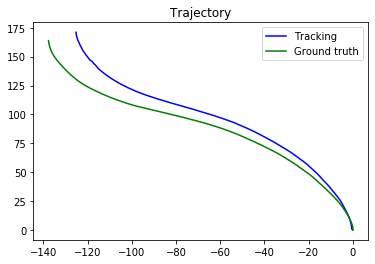

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


602 features left after pose estimation.
act scale 0.021636285127644428


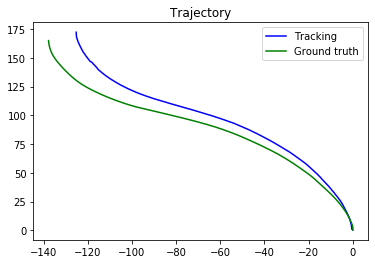

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


642 features left after pose estimation.
act scale 0.009889884833113795


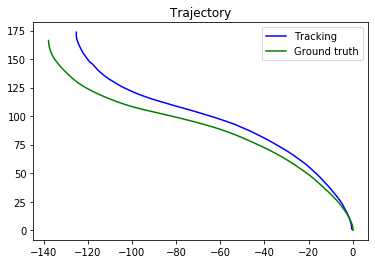

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


728 features left after pose estimation.
act scale 0.13910563193873468


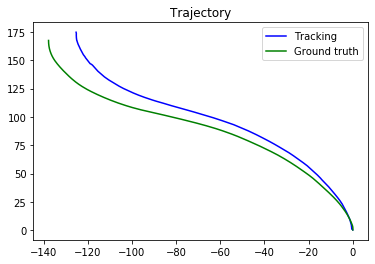

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


723 features left after pose estimation.
act scale 0.07272798078709608


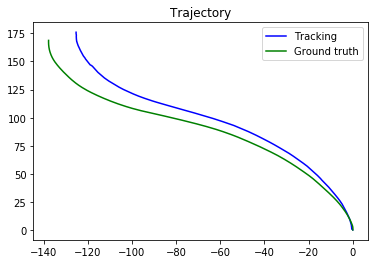

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


701 features left after pose estimation.
act scale 0.03511856443035438


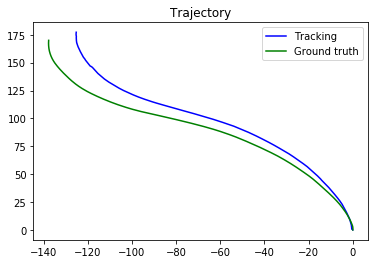

/Users/don/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


638 features left after pose estimation.
act scale 0.0673333127142725


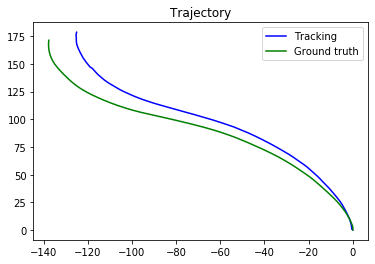

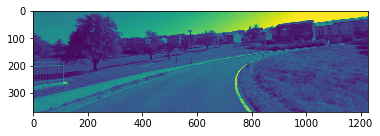

In [11]:
# Modified by Vardhan Dongre ( tracking points between consecutive frames)

#detector = cv2.GFTTDetector_create()
#detector = cv2.xfeatures2d.SIFT_create()
path = 'KITTI_data/data_odometry_gray/09/image_0/'
dataset_reader = DatasetReaderKITTI(path)
#dataset_reader = DatasetReaderKITTI("../videos/KITTI/sequences/00/")

K = dataset_reader.readCameraMatrix()
prev_points = np.empty(0)
prev_frame_BGR = dataset_reader.readFrame(2)
kitti_positions, track_positions = [], []
camera_rot, camera_pos = np.eye(3), np.zeros((3,1))
T_prev = np.zeros((3,1))
plt.show()

# Process next frames
for i in range(1,len(points)-2):
    if points[i] == [[],[]]:
        continue
    curr_frame_BGR = dataset_reader.readFrame(i)
    prev_frame = cv2.cvtColor(prev_frame_BGR, cv2.COLOR_BGR2GRAY)
    #prev_frame = cv2.resize(prev_frame, (160,120) )
    curr_frame = cv2.cvtColor(curr_frame_BGR, cv2.COLOR_BGR2GRAY)
    #curr_frame = cv2.resize(curr_frame, (160,120) )

    curr_points = np.array(points[i][1])
    prev_points = np.array(points[i][0])
#     print(i)
#     print(curr_points)
#     print(prev_points)
    
    # Essential matrix, pose estimation
    E, mask = cv2.findEssentialMat(curr_points, prev_points, K, cv2.RANSAC, 0.99, 0.5, None)
    prev_points = np.array([pt for (idx, pt) in enumerate(prev_points) if mask[idx] == 1])
    curr_points = np.array([pt for (idx, pt) in enumerate(curr_points) if mask[idx] == 1])


    _, R, T, _ = cv2.recoverPose(E, curr_points, prev_points, K)
    print(f"{len(curr_points)} features left after pose estimation.")
    actual_scale = np.sqrt((T[0,0]-T_prev[0,0])**2 + (T[1,0]-T_prev[1,0])**2  + (T[2,0]-T_prev[2,0])**2)
    T_prev = T
    # Read groundtruth translation T and absolute scale for computing trajectory
    kitti_pos, kitti_scale = dataset_reader.readGroundtuthPosition(i)

    print("act scale",actual_scale)
    #kitti_scale =1
    if kitti_scale <= 0.1:
        continue

    camera_pos = camera_pos + kitti_scale * camera_rot.dot(T)
    camera_rot = R.dot(camera_rot)
    #print("cam pos",camera_pos)

    kitti_positions.append(kitti_pos)
    track_positions.append(camera_pos)
    updateTrajectoryDrawing(np.array(track_positions), np.array(kitti_positions))
    prev_points = prev_points.astype(int)
    curr_points = curr_points.astype(int)
#     updateTrajectoryDrawing(np.array(track_positions), np.array(track_positions))
    drawFrameFeatures(curr_frame, prev_points, curr_points, i)

    if cv2.waitKey(1) == ord('q'):
        break

    prev_points, prev_frame_BGR = curr_points, curr_frame_BGR

cv2.destroyAllWindows()

#%%

fig, ax = plt.subplots()
ax.imshow(curr_frame)

#%%

gt_pos_arr = np.array(kitti_positions)
track_pos_arr = np.array(track_positions).reshape((len(track_positions),3))

np.save('KITTI_turn_Superpoint.npy',track_pos_arr)
#%%
#new_num_arr = np.load('bloom_turn_SIFT.npy') # load 

In [9]:
points = np.load('points_09.npy',allow_pickle = True)